## 统计类-准确率

In [50]:
import pandas as pd

sta_res_path = '/media/luzhenyang/project/agent_graph_diag/statistics/statistical_result_of_diagnosis.xlsx'
df = pd.read_excel(sta_res_path, sheet_name='Accuracy_easy_to_call_tool(bp)')
df.drop(columns='Index', inplace=True)
seed_model = df.columns

In [51]:
seed_model

Index(['42_own', '42_strict', '42_lenient', '42_FI', '42_CoT', '71_own',
       '71_strict', '71_lenient', '71_FI', '71_CoT', '96_own', '96_strict',
       '96_lenient', '96_FI', '96_CoT', '10_own', '10_strict', '10_lenient',
       '10_FI', '10_CoT', '4_own', '4_strict', '4_lenient', '4_FI', '4_CoT',
       '20_own', '20_strict', '20_lenient', '20_FI', '20_CoT', '23_own',
       '23_strict', '23_lenient', '23_FI', '23_CoT', '9_own', '9_strict',
       '9_lenient', '9_FI', '9_CoT', '7_own', '7_strict', '7_lenient', '7_FI',
       '7_CoT', '1_own', '1_strict', '1_lenient', '1_FI', '1_CoT'],
      dtype='object')

In [52]:
num_calsses = 4
samples_per_calss = 20

acc = {model: [] for model in seed_model}

for model in seed_model:
    acc_for_model = []

    for class_index in range(num_calsses):
        class_start_index = class_index * samples_per_calss
        class_end_index = (class_index + 1) * samples_per_calss
        class_samples = df.loc[class_start_index:class_end_index, model]

        accuracy = (class_samples == '对').mean()
        acc_for_model.append(accuracy)

    acc[model] = acc_for_model

acc_df = pd.DataFrame(acc, index=[f"Pathology {i+1}" for i in range(num_calsses) ])

acc_df.to_csv('/media/luzhenyang/project/agent_graph_diag/statistics/type_accuracy_by_pathology.csv')

In [53]:
acc_df.rename(index={
    'Pathology 1': 'appendicitis', 
    'Pathology 2': 'cholecystitis', 
    'Pathology 3': 'diverticulitis', 
    'Pathology 4': 'pancreatitis'
}, inplace=True)

In [55]:
acc_df.to_csv('/media/luzhenyang/project/agent_graph_diag/statistics/type_accuracy_by_pathology.csv')

# AGAP组内分析

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
import os

# === 加载数据 ===
csv_path = '/media/luzhenyang/project/agent_graph_diag/statistics/type_accuracy_by_pathology.csv'
acc_df = pd.read_csv(csv_path, index_col=0)

# === 创建输出文件夹 ===
output_dir = "/media/luzhenyang/project/agent_graph_diag/statistics_ex_1/in_group"
os.makedirs(output_dir, exist_ok=True)

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
import scikit_posthocs as sp

def add_stat_annotation(ax, x1, x2, y, h, text, fontsize=18, mid_h=None, offset=0.10):
    """
    显著性连线和星号。
    连线不直接连到柱顶，用offset偏离柱顶一点。
    mid_h: 横线高度，相较y的提升，适合跨越中间柱时设置更高。
    """
    line_color = "gray"
    text_color = "dimgray"
    if mid_h is None:
        mid_h = h

    mid_x = (x1 + x2) / 2

    # 左竖线，从 y+offset 到 y+h （不直接从y开始，离柱顶offset）
    ax.plot([x1, x1], [y + offset, y + h], lw=1.2, c=line_color, alpha=0.6)
    # 横线，从 x1 到 x2，在 y + mid_h 高度
    ax.plot([x1, x2], [y + mid_h, y + mid_h], lw=1.2, c=line_color, alpha=0.6)
    # 右竖线，从 y+offset 到 y+h
    ax.plot([x2, x2], [y + offset, y + h], lw=1.2, c=line_color, alpha=0.6)

    # 星号放在横线上方
    ax.text(mid_x, y + mid_h * 1.2, text, ha='center', va='bottom',
            fontsize=fontsize, fontweight='bold', color=text_color)

# ==== 设置 ====
input_csv = "/media/luzhenyang/project/agent_graph_diag/statistics/type_accuracy_by_pathology.csv"
output_dir = "/media/luzhenyang/project/agent_graph_diag/statistics/prompt_type_comparison"
os.makedirs(output_dir, exist_ok=True)

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 18,
    "axes.titleweight": "bold",
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# === 读取数据 ===
acc_df = pd.read_csv(input_csv, index_col=0)

for disease in acc_df.index:
    disease_row = acc_df.loc[disease]

    data = {'seed': [], 'prompt_type': [], 'accuracy': []}
    for col in disease_row.index:
        if '_own' in col:
            data['prompt_type'].append('own')
        elif '_strict' in col:
            data['prompt_type'].append('strict')
        elif '_lenient' in col:
            data['prompt_type'].append('lenient')
        else:
            continue
        data['seed'].append(col.split('_')[0])
        data['accuracy'].append(disease_row[col])

    df_long = pd.DataFrame(data)

    grouped = df_long.groupby("prompt_type")["accuracy"]
    means = grouped.mean()
    sems = grouped.std()

    prompt_types = ['own', 'lenient', 'strict']
    x_pos = np.arange(len(prompt_types))

    # === Kruskal-Wallis + Dunn’s Test ===
    groups = [df_long[df_long['prompt_type'] == pt]['accuracy'] for pt in prompt_types]
    stat, p_kw = kruskal(*groups)

    dunn_res = None
    if p_kw < 0.05:
        dunn_res = sp.posthoc_dunn(df_long, val_col='accuracy', group_col='prompt_type', p_adjust='bonferroni')

    # === 绘图 ===
    plt.figure(figsize=(8, 6.5))
    ax = plt.gca()

    colors = sns.color_palette("colorblind", 3)
    bars = ax.bar(x_pos, means[prompt_types], yerr=sems[prompt_types], capsize=9, width=0.6,
                color=colors, edgecolor='black', linewidth=1.3)

    for i, pt in enumerate(prompt_types):
        y_vals = df_long[df_long['prompt_type'] == pt]['accuracy'].values
        x_vals = np.random.normal(loc=i, scale=0.07, size=len(y_vals))  # jitter更窄更集中
        ax.scatter(x_vals, y_vals, color='dimgray', alpha=0.65, s=50, zorder=10)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(prompt_types, fontweight='bold')
    ax.set_ylim(0, 1.12)
    ax.set_ylabel("Per-class Accuracy", fontsize=16, fontweight='bold')
    ax.set_title(f"{disease.capitalize()} Accuracy by Prompt Type", fontsize=20, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    if dunn_res is not None:
        max_height = max(means[prompt_types] + sems[prompt_types])
        h = 0.035
        step = 0.05
        num_lines = 0

        def get_star(p):
            if p < 0.001:
                return "***"
            elif p < 0.01:
                return "**"
            elif p < 0.05:
                return "*"
            else:
                return None

        pairs = [(0,1), (0,2), (1,2)]
        num_lines = 0
        base_y = max_height + 0.05
        h = 0.04
        offset = 0.015  # 连线起点距离柱顶0.015的偏移

        for i, j in pairs:
            p_val = dunn_res.iloc[i, j]
            star = get_star(p_val)
            if star:
                # y = base_y + num_lines * 0.06
                # 获取两个柱子的实际高度（均值 + sem）
                y1 = means[prompt_types[i]] + sems[prompt_types[i]]
                y2 = means[prompt_types[j]] + sems[prompt_types[j]]
                y_top = max(y1, y2)
                y = y_top + 0.02 + num_lines * 0.05  # 加偏移和间隔
                if (i,j) == (0,2) or (i,j) == (2,0):  # 跨越strict的连线，用更高的横线mid_h
                    mid_h = y + 0.04  # 横线更高
                    add_stat_annotation(ax, x_pos[i], x_pos[j], y, h=h, text=star, fontsize=18, mid_h=mid_h, offset=offset)
                else:
                    # 普通连线，横线高度等于竖线高度
                    add_stat_annotation(ax, x_pos[i], x_pos[j], y, h=h, text=star, fontsize=18, offset=offset)
                num_lines += 1

    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.close()


In [22]:
acc_df = pd.read_csv(input_csv, index_col=0)
disease_list = acc_df.index.tolist()

for idx, disease in enumerate(disease_list):
    # 生成df_long的代码省略...
    disease_row = acc_df.loc[disease]

    data = {'seed': [], 'prompt_type': [], 'accuracy': []}
    for col in disease_row.index:
        if '_own' in col:
            data['prompt_type'].append('own')
        elif '_strict' in col:
            data['prompt_type'].append('strict')
        elif '_lenient' in col:
            data['prompt_type'].append('lenient')
        else:
            continue
        data['seed'].append(col.split('_')[0])
        data['accuracy'].append(disease_row[col])

    df_long = pd.DataFrame(data)

    df_long = pd.DataFrame(data)

    print(f"=== Disease: {disease} ===")
    print("Sample counts by prompt_type:")
    print(df_long['prompt_type'].value_counts())
    print("Sample counts by prompt_type and seed:")
    print(df_long.groupby(['prompt_type', 'seed']).size())
    print("Sample preview:")
    print(df_long.head(10))
    print("-" * 50)

=== Disease: appendicitis ===
Sample counts by prompt_type:
prompt_type
own        10
strict     10
lenient    10
Name: count, dtype: int64
Sample counts by prompt_type and seed:
prompt_type  seed
lenient      1       1
             10      1
             20      1
             23      1
             4       1
             42      1
             7       1
             71      1
             9       1
             96      1
own          1       1
             10      1
             20      1
             23      1
             4       1
             42      1
             7       1
             71      1
             9       1
             96      1
strict       1       1
             10      1
             20      1
             23      1
             4       1
             42      1
             7       1
             71      1
             9       1
             96      1
dtype: int64
Sample preview:
  seed prompt_type  accuracy
0   42         own  1.000000
1   42      strict  0.9047

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
import scikit_posthocs as sp

# ==== 路径设置 ====
input_csv = "/media/luzhenyang/project/agent_graph_diag/statistics/type_accuracy_by_pathology.csv"
output_dir = "/media/luzhenyang/project/agent_graph_diag/statistics/AGAP_in_group"
os.makedirs(output_dir, exist_ok=True)

sns.set_theme(style="whitegrid", font_scale=1.2)
prompt_types = ['own', 'strict', 'lenient']
colors = sns.color_palette("colorblind", 3)
label_map = ['a', 'b', 'c', 'd']

# 读取数据
acc_df = pd.read_csv(input_csv, index_col=0)
disease_list = acc_df.index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axes = axes.flatten()
stat_results = []

for idx, disease in enumerate(disease_list):
    ax = axes[idx]
    disease_row = acc_df.loc[disease]

    data = {'seed': [], 'prompt_type': [], 'accuracy': []}
    for col in disease_row.index:
        for pt in prompt_types:
            if f'_{pt}' in col:
                data['prompt_type'].append(pt)
                data['seed'].append(col.split('_')[0])
                data['accuracy'].append(disease_row[col])
                break
    df_long = pd.DataFrame(data)

    print(disease)
    print(df_long.groupby('prompt_type').size())
    print(df_long.head())

    sns.boxplot(data=df_long, x='prompt_type', y='accuracy', ax=ax,
                order=prompt_types, palette=colors, width=0.6,
                showmeans=True, meanprops={"marker": "o", "markerfacecolor": "white",
                                           "markeredgecolor": "black", "markersize": 6})
    sns.stripplot(data=df_long, x='prompt_type', y='accuracy', ax=ax,
                  order=prompt_types, color='black', size=5, alpha=0.7, jitter=0.2, zorder=10)

    ax.set_title(f"{disease.capitalize()}", fontsize=15, fontweight='bold')
    ax.set_xlabel("")
    if idx % 2 == 0:
        ax.set_ylabel("Accuracy", fontsize=13)
    else:
        ax.set_ylabel("")
    ax.set_ylim(0, 1.05)
    ax.text(-0.15, 1.08, f"{label_map[idx]})", transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')
    sns.despine(ax=ax)

    # 统计检验，保存结果
    groups = [df_long[df_long['prompt_type'] == pt]['accuracy'] for pt in prompt_types]
    stat, p_kw = kruskal(*groups)
    dunn_res = None
    if p_kw < 0.05:
        dunn_res = sp.posthoc_dunn(df_long, val_col='accuracy', group_col='prompt_type', p_adjust='bonferroni')

    for i, pt1 in enumerate(prompt_types):
        for j, pt2 in enumerate(prompt_types):
            if j <= i:
                continue
            p_val = dunn_res.iloc[i, j] if dunn_res is not None else np.nan
            sig = "*" if p_val < 0.05 else "" if not pd.isna(p_val) else "ns"
            stat_results.append({
                "Disease": disease,
                "Comparison": f"{pt1} vs {pt2}",
                "Kruskal_H": round(stat, 4),
                "Kruskal_p": round(p_kw, 4),
                "Dunn_p_adj": round(p_val, 4) if not pd.isna(p_val) else "",
                "Significant": sig
            })

# 保存并打印统计结果
df_stats = pd.DataFrame(stat_results)
print(df_stats)
df_stats.to_csv(os.path.join(output_dir, "prompt_type_stats_by_disease.csv"), index=False)

plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.3)
fig.suptitle("Accuracy across Prompt Types for Each Disease", fontsize=18, fontweight='bold')

plt.savefig(os.path.join(output_dir, "prompt_type_panel_boxplot_clean.png"), dpi=300)
plt.close()

appendicitis
prompt_type
lenient    10
own        10
strict     10
dtype: int64
  seed prompt_type  accuracy
0   42         own  1.000000
1   42      strict  0.904762
2   42     lenient  1.000000
3   71         own  1.000000
4   71      strict  1.000000
cholecystitis
prompt_type
lenient    10
own        10
strict     10
dtype: int64
  seed prompt_type  accuracy
0   42         own  0.904762
1   42      strict  0.571429
2   42     lenient  0.952381
3   71         own  0.809524
4   71      strict  0.619048
diverticulitis
prompt_type
lenient    10
own        10
strict     10
dtype: int64
  seed prompt_type  accuracy
0   42         own  0.857143
1   42      strict  0.619048
2   42     lenient  0.857143
3   71         own  0.904762
4   71      strict  0.571429


/tmp/ipykernel_38895/2478443502.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long, x='prompt_type', y='accuracy', ax=ax,
/tmp/ipykernel_38895/2478443502.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long, x='prompt_type', y='accuracy', ax=ax,
/tmp/ipykernel_38895/2478443502.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long, x='prompt_type', y='accuracy', ax=ax,


pancreatitis
prompt_type
lenient    10
own        10
strict     10
dtype: int64
  seed prompt_type  accuracy
0   42         own      0.85
1   42      strict      0.65
2   42     lenient      0.80
3   71         own      0.85
4   71      strict      0.60
           Disease         Comparison  Kruskal_H  Kruskal_p Dunn_p_adj  \
0     appendicitis      own vs strict     3.4472     0.1784              
1     appendicitis     own vs lenient     3.4472     0.1784              
2     appendicitis  strict vs lenient     3.4472     0.1784              
3    cholecystitis      own vs strict    16.3336     0.0003        1.0   
4    cholecystitis     own vs lenient    16.3336     0.0003     0.0015   
5    cholecystitis  strict vs lenient    16.3336     0.0003     0.0013   
6   diverticulitis      own vs strict    20.3152     0.0000        1.0   
7   diverticulitis     own vs lenient    20.3152     0.0000     0.0013   
8   diverticulitis  strict vs lenient    20.3152     0.0000     0.0001   
9     

/tmp/ipykernel_38895/2478443502.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long, x='prompt_type', y='accuracy', ax=ax,


### 完善统计学方法，对AGAP组内实验进行分析与绘图
1. 正态性检验，回答为什么要用非参数检验方法
2. 采样规模，n
3. Bonferroni Correction， 显式定义adjusted alpha level for Dunn's test
4. 统计学清晰性，+figure legend解释boxplot elements和显著性阈值
5. 描述性统计值，独立表格 descriptive_statistics.csv with mean, median, SD, and IQR for each group

In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, shapiro, f_oneway, levene
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from math import sqrt

# ==== Paths ====
input_csv = "/media/luzhenyang/project/agent_graph_diag/statistics/type_accuracy_by_pathology.csv"
output_dir = "/media/luzhenyang/project/agent_graph_diag/statistics/AGAP_in_group"
os.makedirs(output_dir, exist_ok=True)

# ==== Settings ====
sns.set_theme(style="whitegrid", font_scale=1.2)
prompt_types = ['own', 'strict', 'lenient']
colors = sns.color_palette("colorblind", 3)
label_map = ['a', 'b', 'c', 'd']
alpha_level = 0.05  # Global alpha level for significance

# ==== Functions ====
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    pooled_std = sqrt(((n1-1)*group1.std()**2 + (n2-1)*group2.std()**2)/(n1+n2-2))
    return abs(group1.mean() - group2.mean()) / pooled_std

def cohens_d_corrected(g1, g2):
    n1, n2 = len(g1), len(g2)
    pooled_std = sqrt(((n1-1)*g1.std()**2 + (n2-1)*g2.std()**2)/(n1+n2-2))
    return abs(g1.mean() - g2.mean()) / pooled_std

# ==== Read Data ====
acc_df = pd.read_csv(input_csv, index_col=0)
disease_list = acc_df.index.tolist()

# ==== Initialize Output ====
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
axes = axes.flatten()
stat_results = []
all_df_long = []

# ==== Main Analysis Loop ====
for idx, disease in enumerate(disease_list):
    ax = axes[idx]
    disease_row = acc_df.loc[disease]

    # Reshape data to long format
    data = {'seed': [], 'prompt_type': [], 'accuracy': []}
    for col in disease_row.index:
        for pt in prompt_types:
            if f'_{pt}' in col:
                data['prompt_type'].append(pt)
                data['seed'].append(col.split('_')[0])
                data['accuracy'].append(disease_row[col])
                break
    df_long = pd.DataFrame(data)
    df_long['disease'] = disease
    all_df_long.append(df_long)
    group_sizes = df_long.groupby('prompt_type').size().to_dict()

    # ==== Step 1: Normality and Homoscedasticity Check ====
    normality_results = {}
    all_normal = True
    for pt in prompt_types:
        group_data = df_long[df_long['prompt_type'] == pt]['accuracy']
        _, p_norm = shapiro(group_data)
        normality_results[pt] = p_norm
        if p_norm < 0.05:
            all_normal = False

    # Check homoscedasticity if all groups are normal
    if all_normal:
        _, p_levene = levene(*[df_long[df_long['prompt_type'] == pt]['accuracy'] 
                              for pt in prompt_types])
        if p_levene < 0.05:
            all_normal = False  # Fall back to non-parametric if heteroscedastic

    # ==== Step 2: Statistical Test ====
    tukey_pvals = {}
    dunn_res = None
    
    if all_normal:
        # Parametric: ANOVA + Tukey
        _, p_anova = f_oneway(*[
            df_long[df_long['prompt_type'] == pt]['accuracy']
            for pt in prompt_types
        ])
        
        tukey = pairwise_tukeyhsd(df_long['accuracy'], df_long['prompt_type'])
        
        # 使用 .summary() 提取 Tukey 表
        summary_df = pd.DataFrame(
            tukey.summary().data[1:],  # 跳过表头行
            columns=tukey.summary().data[0]
        )
        summary_df['p-adj'] = summary_df['p-adj'].astype(float)

        # 构建便于查找的字典（正反组合）
        tukey_pvals = {
            (row['group1'], row['group2']): row['p-adj']
            for _, row in summary_df.iterrows()
        }
        tukey_pvals.update({
            (row['group2'], row['group1']): row['p-adj']
            for _, row in summary_df.iterrows()
        })

        test_used = "ANOVA+Tukey"

    else:
        # Non-parametric: Kruskal + Dunn
        stat_kw, p_kw = kruskal(*[
            df_long[df_long['prompt_type'] == pt]['accuracy'] 
            for pt in prompt_types
        ])
        dunn_res = sp.posthoc_dunn(
            df_long, 
            val_col='accuracy', 
            group_col='prompt_type', 
            p_adjust='bonferroni'
        )
        test_used = "Kruskal+Dunn"

    # ==== Step 3: Record Results ====
    for i, pt1 in enumerate(prompt_types):
        for j, pt2 in enumerate(prompt_types):
            if j <= i:
                continue
                
            # Get p-value
            if all_normal:
                p_val = tukey_pvals.get((pt1, pt2), np.nan)
            else:
                p_val = dunn_res.loc[pt1, pt2] if not pd.isna(dunn_res.loc[pt1, pt2]) else np.nan
            
            # Calculate effect size
            group1_data = df_long[df_long['prompt_type'] == pt1]['accuracy']
            group2_data = df_long[df_long['prompt_type'] == pt2]['accuracy']
            eff_size = cohens_d(group1_data, group2_data)
            
            if pd.isna(p_val):
                raise ValueError(f"Missing p-value for {disease} {pt1} vs {pt2}")
            if (eff_size > 0.8) and (p_val > 0.05):
                print(f"Warning: Large effect but non-significant ({eff_size:.2f}, p={p_val:.4f})")
            stat_results.append({
                "Disease": disease,
                "Group1": pt1,
                "Group2": pt2,
                "n_Group1": group_sizes[pt1],
                "n_Group2": group_sizes[pt2],
                "Test_Used": test_used,
                "Normality_p_Group1": normality_results[pt1],
                "Normality_p_Group2": normality_results[pt2],
                "Omnibus_Stat": stat_kw if not all_normal else np.nan,
                "Omnibus_p": p_kw if not all_normal else p_anova,
                "Posthoc_p_adj": p_val,
                "Effect_Size": eff_size,
                "Significance_Threshold": alpha_level / 3
            })

    # ==== Step 4: Plotting ====
    sns.boxplot(
        data=df_long, x='prompt_type', y='accuracy', ax=ax,
        order=prompt_types, palette=colors, width=0.6,
        showmeans=True,
        meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 6}
    )
    sns.stripplot(
        data=df_long, x='prompt_type', y='accuracy', ax=ax,
        order=prompt_types, color='black', size=5, alpha=0.7, jitter=0.2
    )

    # Sample size annotations
    for i, pt in enumerate(prompt_types):
        ax.text(i, -0.1, f"n={group_sizes[pt]}", ha='center', va='top', fontsize=8)

    # Add significance bars
    y_base = df_long['accuracy'].max() + 0.05
    y_step = 0.04
    line_count = 0

    for i, pt1 in enumerate(prompt_types):
        for j, pt2 in enumerate(prompt_types):
            if j <= i:
                continue
                
            # Get p-value
            if all_normal:
                p_val = tukey_pvals.get((pt1, pt2), np.nan)
            else:
                p_val = dunn_res.loc[pt1, pt2] if not pd.isna(dunn_res.loc[pt1, pt2]) else np.nan

            # Draw significance bars
            if p_val < (alpha_level / 3):
                y = y_base + line_count * y_step
                ax.plot([i, j], [y, y], color='black', lw=1.5)
                ax.text((i + j) / 2, y + 0.01, 
                        f"p={p_val:.4f}" if p_val >= 0.0001 else "p<0.0001", 
                        ha='center', va='bottom', fontsize=10)
                line_count += 1

    ax.set_title(f"{disease.capitalize()}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Prompt Type", fontsize=12)
    ax.set_ylabel("Accuracy" if idx % 2 == 0 else "", fontsize=12)
    ax.set_ylim(-0.15, 1.15)
    ax.text(-0.15, 1.08, f"{label_map[idx]})", transform=ax.transAxes, fontsize=16, fontweight='bold')
    sns.despine(ax=ax)

# ==== Save Results ====
df_stats = pd.DataFrame(stat_results)
df_stats.to_csv(os.path.join(output_dir, "AGAP_in_group_statistical_results.csv"), index=False)

# Final figure adjustments
plt.tight_layout() # rect=[0, 0, 1, 0.95]
plt.subplots_adjust(top=0.92, hspace=0.3)
fig.suptitle(
    "Accuracy Across Prompt Types by Disease\n"
    "Boxplots show median (line), IQR (box), and individual data points (dots).\n"
    "Post-hoc tests with Bonferroni correction (α=0.0167 per comparison).",
    fontsize=12, fontweight='bold',  y=1.03
)
plt.savefig(os.path.join(output_dir, "AGAP_in_group_accuracy_comparison_panel.png"), dpi=300, bbox_inches='tight')
plt.close()

# ==== Descriptive Statistics ====
all_df_long = pd.concat(all_df_long, ignore_index=True)
summary_stats = all_df_long.groupby(['disease', 'prompt_type']).agg(
    n=('accuracy', 'size'),
    mean_accuracy=('accuracy', 'mean'),
    std_accuracy=('accuracy', 'std'),
    median_accuracy=('accuracy', 'median'),
    iqr_accuracy=('accuracy', lambda x: np.percentile(x, 75) - np.percentile(x, 25))
)
summary_stats.to_csv(os.path.join(output_dir, "AGAP_in_group_descriptive_statistics.csv"))

/tmp/ipykernel_38895/1007443114.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_38895/1007443114.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_38895/1007443114.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_38895/1007443114.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


# 主实验分析，5种LM不同范式诊断性能对比

In [1]:
import pandas as pd

In [2]:
acc_in_lm = pd.read_csv('/media/luzhenyang/project/agent_graph_diag/statistics/type_accuracy_by_pathology.csv', index_col=0)
acc_in_lm.columns

Index(['42_own', '42_strict', '42_lenient', '42_FI', '42_CoT', '71_own',
       '71_strict', '71_lenient', '71_FI', '71_CoT', '96_own', '96_strict',
       '96_lenient', '96_FI', '96_CoT', '10_own', '10_strict', '10_lenient',
       '10_FI', '10_CoT', '4_own', '4_strict', '4_lenient', '4_FI', '4_CoT',
       '20_own', '20_strict', '20_lenient', '20_FI', '20_CoT', '23_own',
       '23_strict', '23_lenient', '23_FI', '23_CoT', '9_own', '9_strict',
       '9_lenient', '9_FI', '9_CoT', '7_own', '7_strict', '7_lenient', '7_FI',
       '7_CoT', '1_own', '1_strict', '1_lenient', '1_FI', '1_CoT'],
      dtype='object')

In [3]:
acc_in_lm.head()

,42_own,42_strict,42_lenient,42_FI,42_CoT,71_own,71_strict,71_lenient,71_FI,71_CoT,...,7_own,7_strict,7_lenient,7_FI,7_CoT,1_own,1_strict,1_lenient,1_FI,1_CoT
appendicitis,1.000000,0.904762,1.000000,0.904762,0.904762,1.000000,1.000000,1.000000,0.904762,0.904762,...,0.952381,0.952381,0.952381,1.000000,1.000000,1.00,1.000000,1.0,1.000000,0.952381
cholecystitis,0.904762,0.571429,0.952381,0.714286,0.952381,0.809524,0.619048,0.809524,0.761905,0.857143,...,0.952381,0.809524,0.904762,0.809524,0.761905,1.00,0.761905,1.0,0.761905,0.809524
diverticulitis,0.857143,0.619048,0.857143,0.857143,0.904762,0.904762,0.571429,0.904762,0.952381,1.000000,...,0.904762,0.761905,0.904762,0.952381,1.000000,1.00,0.428571,1.0,0.952381,1.000000
pancreatitis,0.850000,0.650000,0.800000,0.800000,0.850000,0.850000,0.600000,0.800000,0.650000,0.750000,...,1.000000,0.900000,1.000000,0.950000,0.950000,0.95,0.750000,0.9,0.900000,0.750000


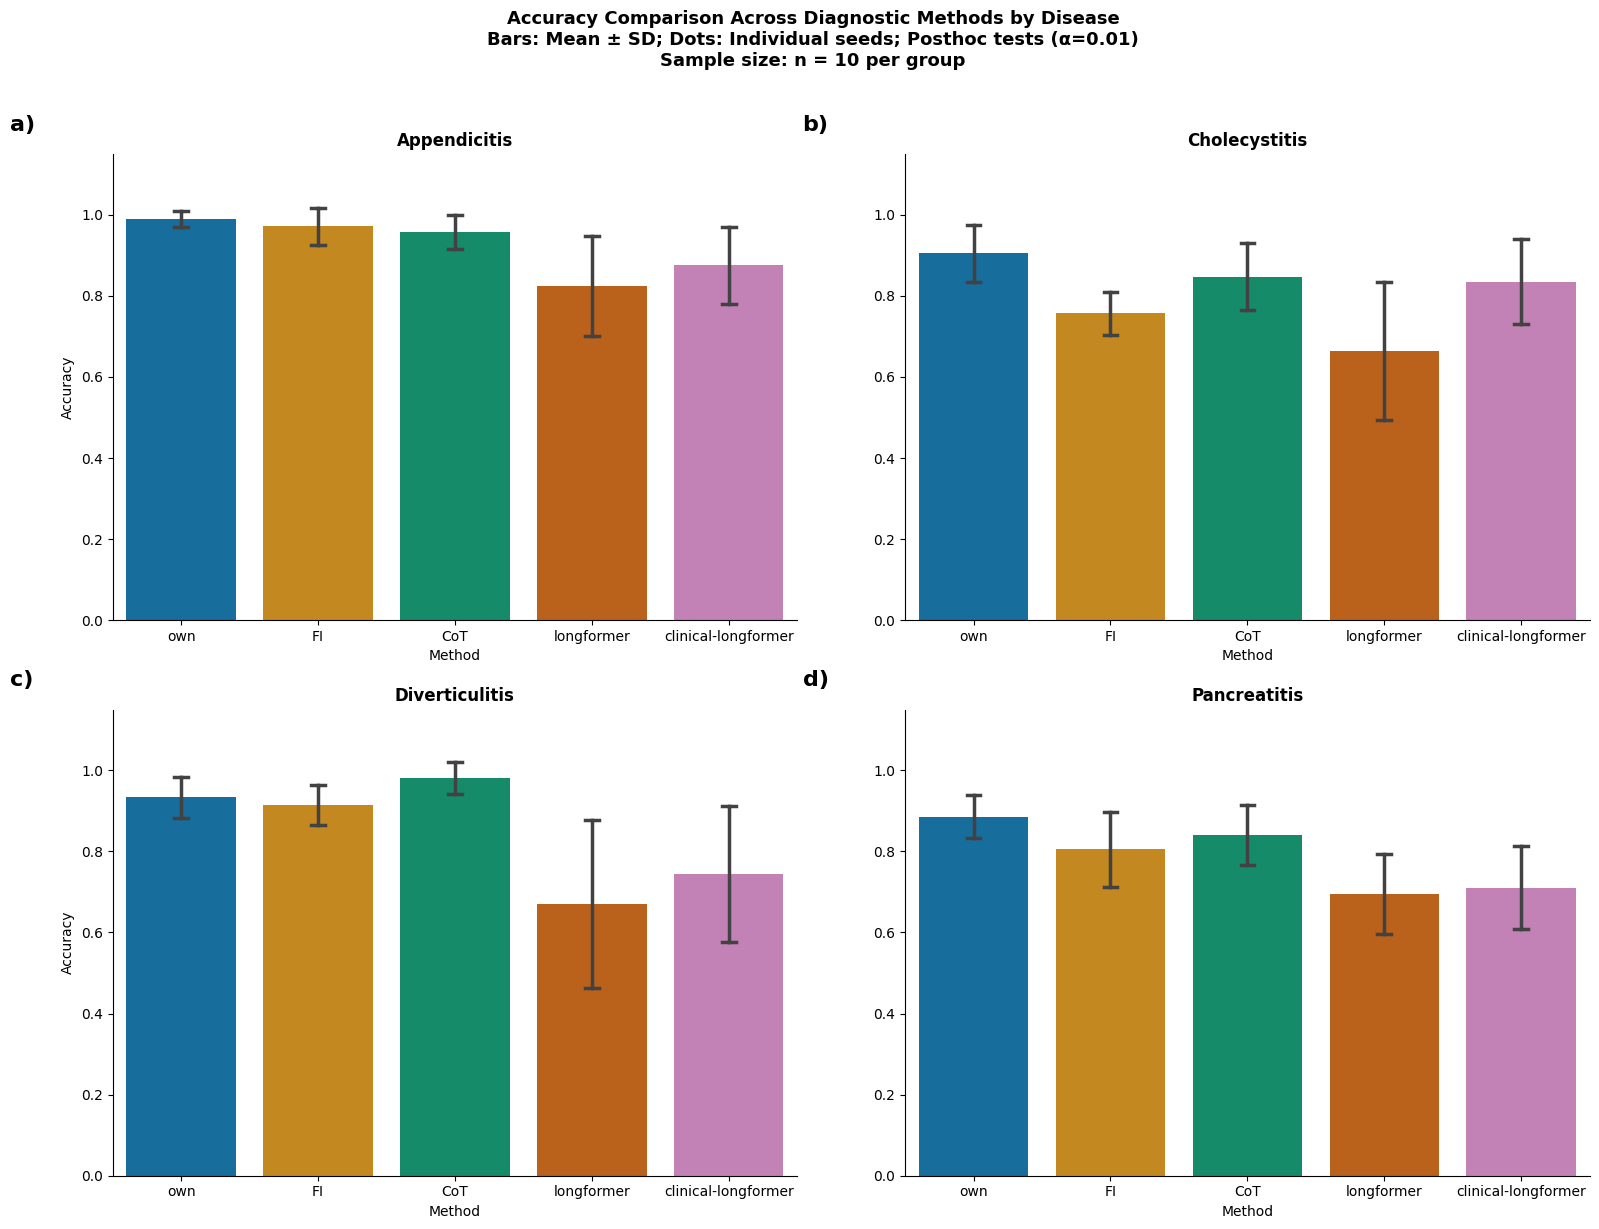

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, shapiro, f_oneway, levene
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from math import sqrt

# ==== Paths ====
llm_csv = "/media/luzhenyang/project/agent_graph_diag/statistics/type_accuracy_by_pathology.csv"
longformer_csv = "/media/luzhenyang/project/agent_graph_diag/lm_classification/normal_longformer_perclass_accuracy.csv"
clinical_csv = "/media/luzhenyang/project/agent_graph_diag/lm_classification/clinical_longformer_perclass_accuracy.csv"
output_dir = "/media/luzhenyang/project/agent_graph_diag/statistics/AGAP_main_comp"
os.makedirs(output_dir, exist_ok=True)
method_order = ["own", "FI", "CoT", "longformer", "clinical-longformer"]
# ==== Melt LLM data ====
# LLM 类方法
df_llm = pd.read_csv(llm_csv, index_col=0)

# ==== Functions ====
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    pooled_std = sqrt(((n1-1)*group1.std()**2 + (n2-1)*group2.std()**2)/(n1+n2-2))
    return abs(group1.mean() - group2.mean()) / pooled_std

def cohens_d_corrected(g1, g2):
    n1, n2 = len(g1), len(g2)
    pooled_std = sqrt(((n1-1)*g1.std()**2 + (n2-1)*g2.std()**2)/(n1+n2-2))
    return abs(g1.mean() - g2.mean()) / pooled_std

palette = sns.color_palette("colorblind", len(method_order))
method_colors = dict(zip(method_order, palette))

# 提取 own、FI、CoT
df_llm_filtered = df_llm.loc[:, df_llm.columns.str.contains('own|FI|CoT')]
long_data = []

for col in df_llm_filtered.columns:
    seed, method = col.split('_')
    for disease in df_llm.index:
        acc = df_llm.loc[disease, col]
        long_data.append({
            'seed': int(seed),
            'method': method,
            'disease': disease,
            'accuracy': acc
        })

# ==== Melt Longformer data ====
df_longformer = pd.read_csv(longformer_csv)
df_longformer = df_longformer.melt(id_vars=['Seed'], var_name='disease', value_name='accuracy')
df_longformer['method'] = 'longformer'
df_longformer.rename(columns={'Seed': 'seed'}, inplace=True)


# ==== Melt Clinical-Longformer data ====
df_clinical = pd.read_csv(clinical_csv)
df_clinical = df_clinical.melt(id_vars=['Seed'], var_name='disease', value_name='accuracy')
df_clinical['method'] = 'clinical-longformer'
df_clinical.rename(columns={'Seed': 'seed'}, inplace=True)

# ==== Merge all ====
df_all = pd.concat([pd.DataFrame(long_data), df_longformer, df_clinical], ignore_index=True)

# ==== 统计分析 & 可视化 ====
summary_records = []
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
disease_list = df_all['disease'].unique()
label_map = ['a', 'b', 'c', 'd']

for idx, disease in enumerate(disease_list):
    ax = axes[idx]
    df_d = df_all[df_all['disease'] == disease]
    
    # 正态性检验
    normality = {m: shapiro(df_d[df_d['method'] == m]['accuracy'])[1] 
                 for m in method_order if (df_d['method'] == m).sum() >= 3}
    all_normal = all(p > 0.05 for p in normality.values())

    # 方差齐性检验
    if all_normal:
        _, p_levene = levene(*[df_d[df_d['method'] == m]['accuracy'] for m in method_order])
        if p_levene < 0.05:
            all_normal = False

    # 统计检验
    if all_normal:
        _, p_omni = f_oneway(*[df_d[df_d['method'] == m]['accuracy'] for m in method_order])
        posthoc = pairwise_tukeyhsd(df_d['accuracy'], df_d['method'])
        tukey_df = pd.DataFrame(posthoc.summary().data[1:], columns=posthoc.summary().data[0])
        tukey_pvals = {
            (row['group1'], row['group2']): float(row['p-adj'])
            for _, row in tukey_df.iterrows()
        }
        test_used = "ANOVA+Tukey"
    else:
        stat_kw, p_omni = kruskal(*[df_d[df_d['method'] == m]['accuracy'] for m in method_order])
        posthoc = sp.posthoc_dunn(
            df_d, val_col='accuracy', group_col='method', p_adjust='bonferroni'
        )
        tukey_pvals = posthoc.stack().to_dict()
        test_used = "Kruskal+Dunn"

    # 记录统计结果
    for i in range(len(method_order)):
        for j in range(i+1, len(method_order)):
            m1, m2 = method_order[i], method_order[j]
            g1 = df_d[df_d['method'] == m1]['accuracy']
            g2 = df_d[df_d['method'] == m2]['accuracy']
            if len(g1) == 0 or len(g2) == 0:
                continue
            p_val = tukey_pvals.get((m1, m2), tukey_pvals.get((m2, m1), np.nan))
            effect = cohens_d(g1, g2)
            summary_records.append({
                'disease': disease, 'method1': m1, 'method2': m2,
                'p_value': p_val, 'effect_size': effect, 'test_used': test_used,
                'n1': len(g1), 'n2': len(g2)
            })

    # 可视化
    sns.barplot(data=df_d, x='method', y='accuracy', ax=ax,
            order=method_order, errorbar='sd', palette=method_colors, capsize=0.1, err_kws={'linewidth': 2.5}, hue='method', legend=False)

    # sns.stripplot(data=df_d, x='method', y='accuracy', ax=ax,
    #               order=method_order, color='black', size=5, alpha=0.7, jitter=0.2)

    ax.set_title(f"{disease.capitalize()}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Method")
    ax.set_ylabel("Accuracy" if idx % 2 == 0 else "")
    ax.text(-0.15, 1.05, f"{label_map[idx]})", transform=ax.transAxes, fontsize=16, fontweight='bold')
    ax.set_ylim(0, 1.15)
    sns.despine(ax=ax)

# 保存统计表 & 图像
df_summary = pd.DataFrame(summary_records)
df_summary.to_csv(os.path.join(output_dir, "AGAP_main_comparison_stats.csv"), index=False)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle(
    "Accuracy Comparison Across Diagnostic Methods by Disease\n"
    "Bars: Mean ± SD; Dots: Individual seeds; Posthoc tests (α=0.01)\n" 
    "Sample size: n = 10 per group",
    fontsize=13, fontweight='bold', y=1.02
)
plt.savefig(os.path.join(output_dir, "AGAP_main_methods_accuracy_comparison_wo_stripplot.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()


# ==== Descriptive Statistics ====
# df_all_methods = pd.concat(df_all_long, ignore_index=True)

summary_stats = df_all.groupby(['disease', 'method']).agg(
    n=('accuracy', 'size'),
    mean_accuracy=('accuracy', 'mean'),
    std_accuracy=('accuracy', 'std'),
    median_accuracy=('accuracy', 'median'),
    iqr_accuracy=('accuracy', lambda x: np.percentile(x, 75) - np.percentile(x, 25))
)

summary_stats.to_csv(os.path.join(output_dir, "AGAP_main_all_methods_descriptive_statistics.csv"))

#### 修改标注

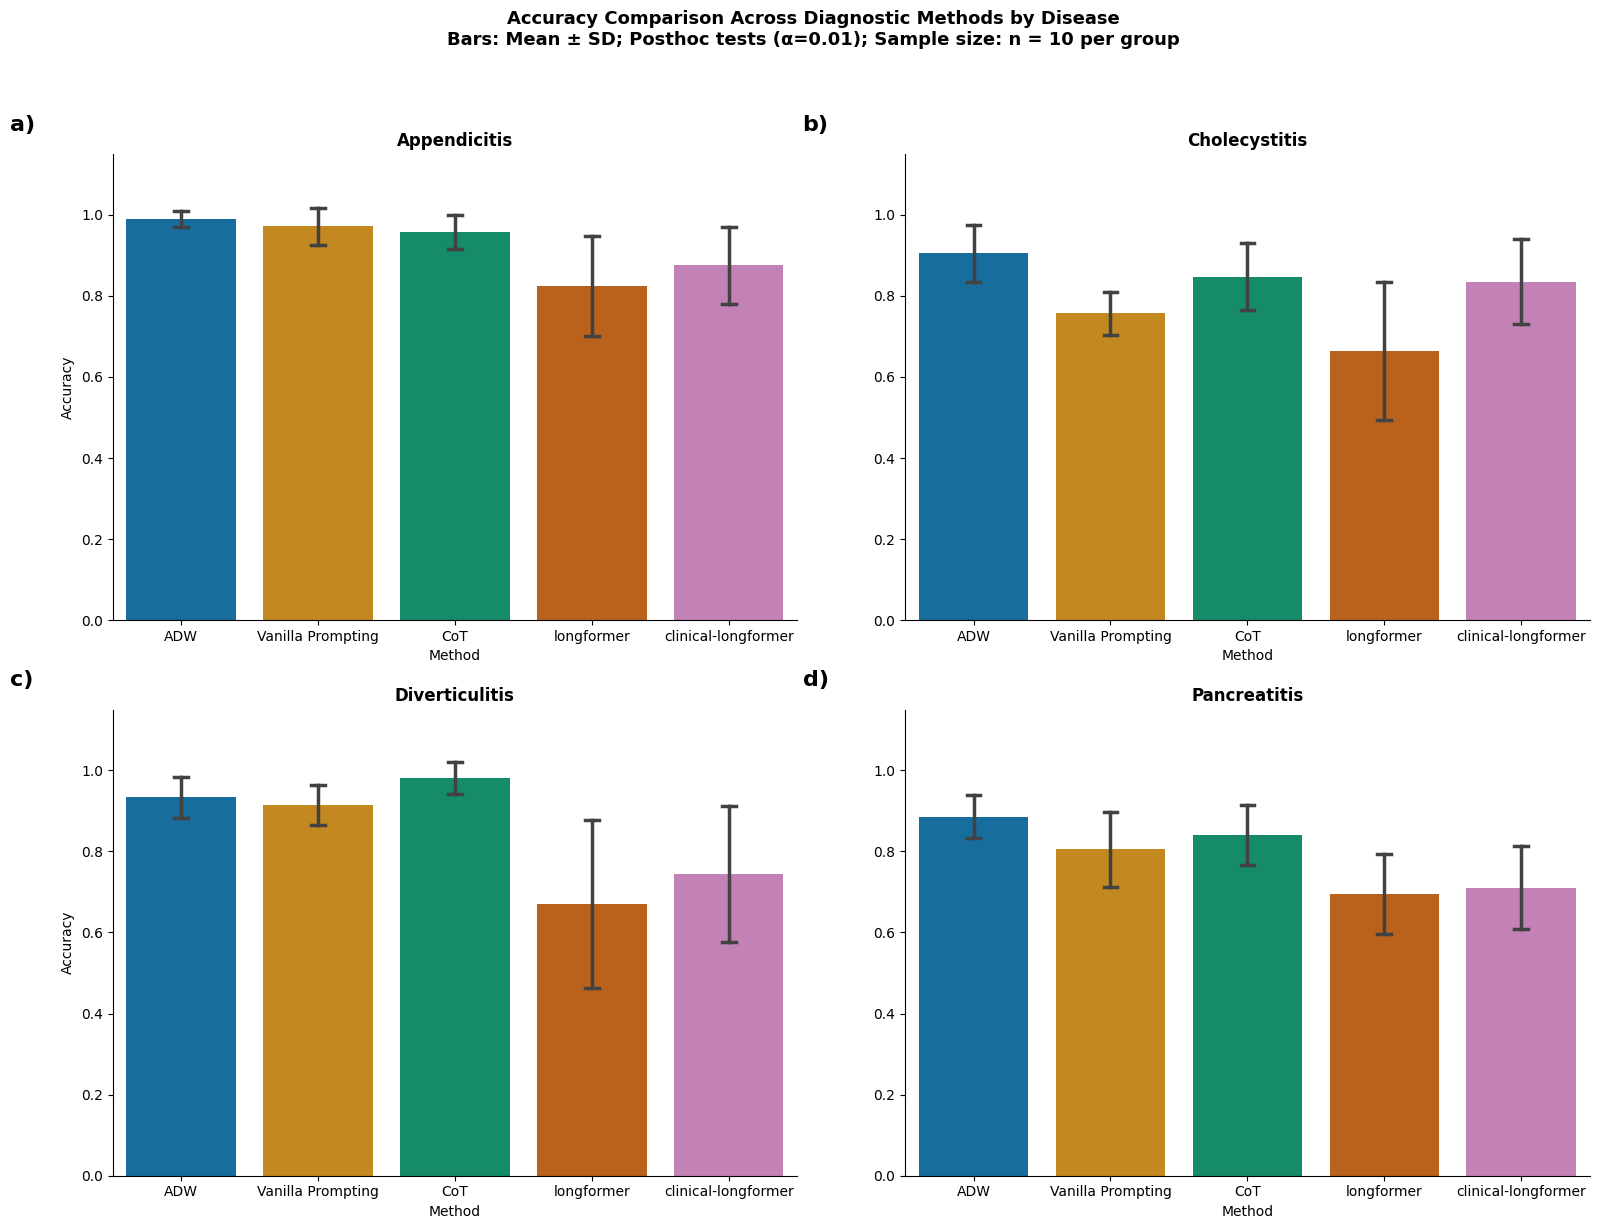

In [29]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, shapiro, f_oneway, levene
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from math import sqrt

# ==== Paths ====
llm_csv = "/media/luzhenyang/project/agent_graph_diag/statistics/type_accuracy_by_pathology.csv"
longformer_csv = "/media/luzhenyang/project/agent_graph_diag/lm_classification/normal_longformer_perclass_accuracy.csv"
clinical_csv = "/media/luzhenyang/project/agent_graph_diag/lm_classification/clinical_longformer_perclass_accuracy.csv"
output_dir = "/media/luzhenyang/project/agent_graph_diag/statistics/AGAP_main_comp"
os.makedirs(output_dir, exist_ok=True)

# ==== New method names ====
method_order = ["ADW", "Vanilla Prompting", "CoT", "longformer", "clinical-longformer"]

# ==== Load and parse LLM data ====
df_llm = pd.read_csv(llm_csv, index_col=0)

# ==== Map raw method labels ====
method_rename_map = {
    'own': 'ADW',
    'FI': 'Vanilla Prompting',
    'CoT': 'CoT'
}

# ==== Filter and rename columns ====
df_llm_filtered = df_llm.loc[:, df_llm.columns.str.contains('own|FI|CoT')]

long_data = []
for col in df_llm_filtered.columns:
    seed, raw_method = col.split('_')
    method = method_rename_map.get(raw_method, raw_method)  # Rename here
    for disease in df_llm.index:
        acc = df_llm.loc[disease, col]
        long_data.append({
            'seed': int(seed),
            'method': method,
            'disease': disease,
            'accuracy': acc
        })

# ==== Longformer ====
df_longformer = pd.read_csv(longformer_csv)
df_longformer = df_longformer.melt(id_vars=['Seed'], var_name='disease', value_name='accuracy')
df_longformer['method'] = 'longformer'
df_longformer.rename(columns={'Seed': 'seed'}, inplace=True)

# ==== Clinical-Longformer ====
df_clinical = pd.read_csv(clinical_csv)
df_clinical = df_clinical.melt(id_vars=['Seed'], var_name='disease', value_name='accuracy')
df_clinical['method'] = 'clinical-longformer'
df_clinical.rename(columns={'Seed': 'seed'}, inplace=True)

# ==== Merge all ====
df_all = pd.concat([pd.DataFrame(long_data), df_longformer, df_clinical], ignore_index=True)

# ==== Method Color Map ====
palette = sns.color_palette("colorblind", len(method_order))
method_colors = dict(zip(method_order, palette))

# ==== Statistical Analysis & Plotting ====
summary_records = []
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
disease_list = df_all['disease'].unique()
label_map = ['a', 'b', 'c', 'd']

def cohens_d(g1, g2):
    n1, n2 = len(g1), len(g2)
    pooled_std = sqrt(((n1-1)*g1.std()**2 + (n2-1)*g2.std()**2)/(n1+n2-2))
    return abs(g1.mean() - g2.mean()) / pooled_std

for idx, disease in enumerate(disease_list):
    ax = axes[idx]
    df_d = df_all[df_all['disease'] == disease]
    
    # 正态性检验
    normality = {m: shapiro(df_d[df_d['method'] == m]['accuracy'])[1] 
                 for m in method_order if (df_d['method'] == m).sum() >= 3}
    all_normal = all(p > 0.05 for p in normality.values())

    # 方差齐性检验
    if all_normal:
        _, p_levene = levene(*[df_d[df_d['method'] == m]['accuracy'] for m in method_order])
        if p_levene < 0.05:
            all_normal = False

    # 统计检验
    if all_normal:
        _, p_omni = f_oneway(*[df_d[df_d['method'] == m]['accuracy'] for m in method_order])
        posthoc = pairwise_tukeyhsd(df_d['accuracy'], df_d['method'])
        tukey_df = pd.DataFrame(posthoc.summary().data[1:], columns=posthoc.summary().data[0])
        tukey_pvals = {
            (row['group1'], row['group2']): float(row['p-adj'])
            for _, row in tukey_df.iterrows()
        }
        test_used = "ANOVA+Tukey"
    else:
        stat_kw, p_omni = kruskal(*[df_d[df_d['method'] == m]['accuracy'] for m in method_order])
        posthoc = sp.posthoc_dunn(
            df_d, val_col='accuracy', group_col='method', p_adjust='bonferroni'
        )
        tukey_pvals = posthoc.stack().to_dict()
        test_used = "Kruskal+Dunn"

    # 记录统计结果
    for i in range(len(method_order)):
        for j in range(i+1, len(method_order)):
            m1, m2 = method_order[i], method_order[j]
            g1 = df_d[df_d['method'] == m1]['accuracy']
            g2 = df_d[df_d['method'] == m2]['accuracy']
            if len(g1) == 0 or len(g2) == 0:
                continue
            p_val = tukey_pvals.get((m1, m2), tukey_pvals.get((m2, m1), np.nan))
            effect = cohens_d(g1, g2)
            summary_records.append({
                'disease': disease, 'method1': m1, 'method2': m2,
                'p_value': p_val, 'effect_size': effect, 'test_used': test_used,
                'n1': len(g1), 'n2': len(g2)
            })

    # 绘图
    sns.barplot(data=df_d, x='method', y='accuracy', ax=ax,
                order=method_order, errorbar='sd', palette=method_colors, capsize=0.1,
                err_kws={'linewidth': 2.5}, hue='method', legend=False)

    ax.set_title(f"{disease.capitalize()}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Method")
    ax.set_ylabel("Accuracy" if idx % 2 == 0 else "")
    ax.text(-0.15, 1.05, f"{label_map[idx]})", transform=ax.transAxes, fontsize=16, fontweight='bold')
    ax.set_ylim(0, 1.15)
    sns.despine(ax=ax)

# ==== Save Stats & Figures ====
df_summary = pd.DataFrame(summary_records)
df_summary.to_csv(os.path.join(output_dir, "AGAP_main_comparison_stats.csv"), index=False)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle(
    "Accuracy Comparison Across Diagnostic Methods by Disease\n"
    "Bars: Mean ± SD; Posthoc tests (α=0.01); Sample size: n = 10 per group",
    fontsize=13, fontweight='bold', y=1.02
)
plt.savefig(os.path.join(output_dir, "AGAP_main_methods_accuracy_comparison_wo_stripplot.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# ==== Descriptive Statistics ====
summary_stats = df_all.groupby(['disease', 'method']).agg(
    n=('accuracy', 'size'),
    mean_accuracy=('accuracy', 'mean'),
    std_accuracy=('accuracy', 'std'),
    median_accuracy=('accuracy', 'median'),
    iqr_accuracy=('accuracy', lambda x: np.percentile(x, 75) - np.percentile(x, 25))
)

summary_stats.to_csv(os.path.join(output_dir, "AGAP_main_all_methods_descriptive_statistics.csv"))


In [36]:
des_stats_AGAP_main = pd.read_csv('/media/luzhenyang/project/agent_graph_diag/statistics/AGAP_in_group/AGAP_in_group_descriptive_statistics.csv')

In [37]:
print(des_stats_AGAP_main)

           disease prompt_type   n  mean_accuracy  std_accuracy  \
0     appendicitis     lenient  10       0.985714      0.032140   
1     appendicitis         own  10       0.990476      0.020078   
2     appendicitis      strict  10       0.957143      0.052405   
3    cholecystitis     lenient  10       0.904762      0.077762   
4    cholecystitis         own  10       0.904762      0.070986   
5    cholecystitis      strict  10       0.709524      0.099000   
6   diverticulitis     lenient  10       0.909524      0.057010   
7   diverticulitis         own  10       0.933333      0.051189   
8   diverticulitis      strict  10       0.523810      0.138378   
9     pancreatitis     lenient  10       0.855000      0.064334   
10    pancreatitis         own  10       0.885000      0.052967   
11    pancreatitis      strict  10       0.745000      0.098460   

    median_accuracy  iqr_accuracy  
0          1.000000      0.000000  
1          1.000000      0.000000  
2          0.976190 

In [33]:
import pandas as pd
from docx import Document
from docx.shared import Inches

# 原始数据载入（从用户消息中复制过来）
data = {
    "disease": ["appendicitis"]*10 + ["cholecystitis"]*10 + ["diverticulitis"]*10 + ["pancreatitis"]*10,
    "method1": [
        "ADW", "ADW", "ADW", "ADW", "Vanilla Prompting", "Vanilla Prompting", "Vanilla Prompting", "CoT", "CoT", "longformer",
        "ADW", "ADW", "ADW", "ADW", "Vanilla Prompting", "Vanilla Prompting", "Vanilla Prompting", "CoT", "CoT", "longformer",
        "ADW", "ADW", "ADW", "ADW", "Vanilla Prompting", "Vanilla Prompting", "Vanilla Prompting", "CoT", "CoT", "longformer",
        "ADW", "ADW", "ADW", "ADW", "Vanilla Prompting", "Vanilla Prompting", "Vanilla Prompting", "CoT", "CoT", "longformer"
    ],
    "method2": [
        "Vanilla Prompting", "CoT", "longformer", "clinical-longformer", "CoT", "longformer", "clinical-longformer", "longformer", "clinical-longformer", "clinical-longformer",
        "Vanilla Prompting", "CoT", "longformer", "clinical-longformer", "CoT", "longformer", "clinical-longformer", "longformer", "clinical-longformer", "clinical-longformer",
        "Vanilla Prompting", "CoT", "longformer", "clinical-longformer", "CoT", "longformer", "clinical-longformer", "longformer", "clinical-longformer", "clinical-longformer",
        "Vanilla Prompting", "CoT", "longformer", "clinical-longformer", "CoT", "longformer", "clinical-longformer", "longformer", "clinical-longformer", "clinical-longformer"
    ],
    "p_value": [
        1.0, 1.0, 0.000196, 0.00346, 1.0, 0.004275, 0.046443, 0.03432, 0.254593, 1.0,
        0.017285, 1.0, 0.000784, 0.805388, 0.505325, 1.0, 1.0, 0.055803, 1.0, 0.276807,
        1.0, 1.0, 0.009061, 0.08015, 0.585351, 0.045468, 0.299487, 0.000023, 0.000486, 1.0,
        0.723766, 1.0, 0.001012, 0.003361, 1.0, 0.365249, 0.736153, 0.04817, 0.118363, 1.0
    ],
    "effect_size": [
        0.536656, 1.01865, 1.877141, 1.681631, 0.325396, 1.576448, 1.291804, 1.438489, 1.119573, 0.454859,
        2.366022, 0.737928, 1.840088, 0.775661, 1.299151, 0.73232, 0.934411, 1.363616, 0.132675, 1.201248,
        0.379473, 1.035098, 1.745707, 1.52139, 1.484924, 1.623033, 1.372039, 2.084597, 1.938198, 0.398292,
        1.060143, 0.700649, 2.403331, 2.150033, 0.417916, 1.150657, 0.973968, 1.666618, 1.458517, 0.149482
    ],
    "test_used": ["Kruskal+Dunn"] * 40,
    "n1": [10] * 40,
    "n2": [10] * 40,
}

df = pd.DataFrame(data)

# 筛选出满足条件的行：effect_size > 1.5 且 p < 0.01
filtered_df = df[(df["effect_size"] > 1.5) & (df["p_value"] < 0.01)]

# 写入 Word 文件函数
def export_to_docx(dataframe, filename, note=None):
    doc = Document()
    if note:
        doc.add_paragraph(note)
    table = doc.add_table(rows=1, cols=len(dataframe.columns))
    table.style = 'Table Grid'
    hdr_cells = table.rows[0].cells
    for i, col_name in enumerate(dataframe.columns):
        hdr_cells[i].text = str(col_name)
    for _, row in dataframe.iterrows():
        row_cells = table.add_row().cells
        for i, item in enumerate(row):
            row_cells[i].text = str(item)
    doc.save(f"/media/luzhenyang/project/agent_graph_diag/statistics/AGAP_main_comp/{filename}")

# 导出两个docx文件
export_to_docx(df, "full_method_comparisons.docx")
export_to_docx(filtered_df, "filtered_method_comparisons.docx", note="Only method comparisons with effect size > 1.5 and p < 0.01 are shown.")


# 统计t检验

In [1]:
import pandas as pd
df = pd.read_csv('/media/luzhenyang/project/agent_graph_diag/statistics/type_accuracy_by_pathology.csv', index_col=0)
print(df.shape)
print(df.columns)
print(df.head())

(4, 50)
Index(['42_own', '42_strict', '42_lenient', '42_FI', '42_CoT', '71_own',
       '71_strict', '71_lenient', '71_FI', '71_CoT', '96_own', '96_strict',
       '96_lenient', '96_FI', '96_CoT', '10_own', '10_strict', '10_lenient',
       '10_FI', '10_CoT', '4_own', '4_strict', '4_lenient', '4_FI', '4_CoT',
       '20_own', '20_strict', '20_lenient', '20_FI', '20_CoT', '23_own',
       '23_strict', '23_lenient', '23_FI', '23_CoT', '9_own', '9_strict',
       '9_lenient', '9_FI', '9_CoT', '7_own', '7_strict', '7_lenient', '7_FI',
       '7_CoT', '1_own', '1_strict', '1_lenient', '1_FI', '1_CoT'],
      dtype='object')
                  42_own  42_strict  42_lenient     42_FI    42_CoT    71_own  \
appendicitis    1.000000   0.904762    1.000000  0.904762  0.904762  1.000000   
cholecystitis   0.904762   0.571429    0.952381  0.714286  0.952381  0.809524   
diverticulitis  0.857143   0.619048    0.857143  0.857143  0.904762  0.904762   
pancreatitis    0.850000   0.650000    0.800000  

In [40]:
df_long = df.copy()
df_long.columns = pd.MultiIndex.from_tuples(
    [col.split('_') for col in df.columns ], names=['seed', 'mode']
)

df_long = df_long.stack(level=['seed', 'mode']).reset_index()
df_long.columns = ['pathology', 'seed', 'mode', 'accuracy']
df_long['seed'] = df_long['seed'].astype(int)
df_long

/tmp/ipykernel_6681/2871546821.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_long = df_long.stack(level=['seed', 'mode']).reset_index()


,pathology,seed,mode,accuracy
0,appendicitis,1,own,1.000000
1,appendicitis,1,strict,1.000000
2,appendicitis,1,lenient,1.000000
3,appendicitis,1,FI,1.000000
4,appendicitis,1,CoT,0.952381
...,...,...,...,...
195,pancreatitis,96,own,0.850000
196,pancreatitis,96,strict,0.850000
197,pancreatitis,96,lenient,0.850000
198,pancreatitis,96,FI,0.800000


In [41]:
from scipy.stats import ttest_rel

for pathology in df_long['pathology'].unique():
    sub = df_long[ df_long['pathology'] == pathology ]
    acc_own = sub[ sub['mode'] == 'own' ].sort_values(by='seed')['accuracy']
    acc_FI = sub[ sub['mode'] == 'FI' ].sort_values(by='seed')['accuracy']

    t_stat, p_val_two_tailed = ttest_rel(acc_own, acc_FI)
    if t_stat > 0:
        p_val_two_tailed = p_val_two_tailed / 2
    else:
        p_val_two_tailed = 1 - p_val_two_tailed / 2
    print(f"{pathology}: t = {t_stat:.3f}, p = {p_val_two_tailed:.4f}")

appendicitis: t = 1.078, p = 0.1546
cholecystitis: t = 6.146, p = 0.0001
diverticulitis: t = 0.885, p = 0.1997
pancreatitis: t = 4.311, p = 0.0010


In [42]:
# t检验CoT与FI
from scipy.stats import ttest_rel

for pathology in df_long['pathology'].unique():
    sub = df_long[ df_long['pathology'] == pathology ]
    acc_own = sub[ sub['mode'] == 'CoT' ].sort_values(by='seed')['accuracy']
    acc_FI = sub[ sub['mode'] == 'FI' ].sort_values(by='seed')['accuracy']

    t_stat, p_val_two_tailed = ttest_rel(acc_own, acc_FI)
    if t_stat > 0:
        p_val_two_tailed = p_val_two_tailed / 2
    else:
        p_val_two_tailed = 1 - p_val_two_tailed / 2
    print(f"{pathology}: t = {t_stat:.3f}, p = {p_val_two_tailed:.4f}")

appendicitis: t = -1.964, p = 0.9594
cholecystitis: t = 3.051, p = 0.0069
diverticulitis: t = 3.500, p = 0.0034
pancreatitis: t = 1.481, p = 0.0863


In [43]:
# t检验own与CoT
from scipy.stats import ttest_rel

for pathology in df_long['pathology'].unique():
    sub = df_long[ df_long['pathology'] == pathology ]
    acc_own = sub[ sub['mode'] == 'own' ].sort_values(by='seed')['accuracy']
    acc_FI = sub[ sub['mode'] == 'CoT' ].sort_values(by='seed')['accuracy']

    t_stat, p_val_two_tailed = ttest_rel(acc_own, acc_FI)
    if t_stat > 0:
        p_val_two_tailed = p_val_two_tailed / 2
    else:
        p_val_two_tailed = 1 - p_val_two_tailed / 2
    print(f"{pathology}: t = {t_stat:.3f}, p = {p_val_two_tailed:.4f}")

appendicitis: t = 2.090, p = 0.0331
cholecystitis: t = 2.092, p = 0.0330
diverticulitis: t = -4.743, p = 0.9995
pancreatitis: t = 1.964, p = 0.0406


In [44]:
# t检验own与strict
from scipy.stats import ttest_rel

for pathology in df_long['pathology'].unique():
    sub = df_long[ df_long['pathology'] == pathology ]
    acc_own = sub[ sub['mode'] == 'own' ].sort_values(by='seed')['accuracy']
    acc_FI = sub[ sub['mode'] == 'strict' ].sort_values(by='seed')['accuracy']

    t_stat, p_val_two_tailed = ttest_rel(acc_own, acc_FI)
    if t_stat > 0:
        p_val_two_tailed = p_val_two_tailed / 2
    else:
        p_val_two_tailed = 1 - p_val_two_tailed / 2
    print(f"{pathology}: t = {t_stat:.3f}, p = {p_val_two_tailed:.4f}")

appendicitis: t = 1.909, p = 0.0443
cholecystitis: t = 9.462, p = 0.0000
diverticulitis: t = 7.628, p = 0.0000
pancreatitis: t = 5.250, p = 0.0003


In [45]:
sub = df_long[ df_long['pathology'] == pathology ]
sub

,pathology,seed,mode,accuracy
150,pancreatitis,1,own,0.95
151,pancreatitis,1,strict,0.75
152,pancreatitis,1,lenient,0.90
153,pancreatitis,1,FI,0.90
154,pancreatitis,1,CoT,0.75
155,pancreatitis,10,own,0.85
156,pancreatitis,10,strict,0.70
157,pancreatitis,10,lenient,0.85
158,pancreatitis,10,FI,0.75
159,pancreatitis,10,CoT,0.80


In [46]:
sub = df_long[ df_long['pathology'] == pathology ]
acc_own = sub[ sub['mode'] == 'own' ].sort_values(by='seed')['accuracy']
acc_lenient = sub[ sub['mode'] == 'lenient' ].sort_values(by='seed')['accuracy']

print(len(acc_own), len(acc_lenient))
print(acc_own.index)
print(acc_lenient.index)

10 10
Index([150, 170, 180, 190, 155, 160, 165, 175, 185, 195], dtype='int64')
Index([152, 172, 182, 192, 157, 162, 167, 177, 187, 197], dtype='int64')


In [47]:
# t检验own与lenient
from scipy.stats import ttest_rel

for pathology in df_long['pathology'].unique():
    sub = df_long[ df_long['pathology'] == pathology ]
    acc_own = sub[ sub['mode'] == 'own' ].sort_values(by='seed')['accuracy']
    acc_FI = sub[ sub['mode'] == 'lenient' ].sort_values(by='seed')['accuracy']

    t_stat, p_val_two_tailed = ttest_rel(acc_own, acc_FI)
    if t_stat > 0:
        p_val_two_tailed = p_val_two_tailed / 2
    else:
        p_val_two_tailed = 1 - p_val_two_tailed / 2
    print(f"{pathology}: t = {t_stat:.3f}, p = {p_val_two_tailed:.4f}")

appendicitis: t = 0.429, p = 0.3392
cholecystitis: t = -0.000, p = 0.5000
diverticulitis: t = 1.861, p = 0.0479
pancreatitis: t = 2.714, p = 0.0119


###  使用非参数检验：Wilcoxon signed-rank test，因为Shapiro-Wilk 检验却表明部分数据不服从正态分布

In [49]:
from scipy.stats import wilcoxon

for pathology in df_long['pathology'].unique():
    sub = df_long[df_long['pathology'] == pathology]
    acc_own = sub[sub['mode'] == 'own'].sort_values(by='seed')['accuracy']
    acc_FI = sub[sub['mode'] == 'FI'].sort_values(by='seed')['accuracy']

    stat, p = wilcoxon(acc_own, acc_FI, alternative='greater')  # one-tailed test: own > FI
    print(f"{pathology}: Wilcoxon test → stat = {stat:.3f}, p = {p:.4f}")

appendicitis: Wilcoxon test → stat = 12.000, p = 0.1250
cholecystitis: Wilcoxon test → stat = 55.000, p = 0.0010
diverticulitis: Wilcoxon test → stat = 22.500, p = 0.2891
pancreatitis: Wilcoxon test → stat = 45.000, p = 0.0020


## 非参数检验：Mann–Whitney U 检验

In [51]:
from scipy.stats import mannwhitneyu

for pathology in df_long['pathology'].unique():
    sub = df_long[df_long['pathology'] == pathology]
    acc_own = sub[sub['mode'] == 'own'].sort_values(by='seed')['accuracy']
    acc_FI = sub[sub['mode'] == 'FI'].sort_values(by='seed')['accuracy']

    stat, p = mannwhitneyu(acc_own, acc_FI, alternative='greater')  # one-tailed test: own > FI
    print(f"{pathology}: mannwhitneyu → stat = {stat:.3f}, p = {p:.4f}")


appendicitis: mannwhitneyu → stat = 58.000, p = 0.2274
cholecystitis: mannwhitneyu → stat = 96.000, p = 0.0002
diverticulitis: mannwhitneyu → stat = 60.000, p = 0.2178
pancreatitis: mannwhitneyu → stat = 77.500, p = 0.0185


### shapiro校验数据正态性（<0.05表示偏离正态）

In [52]:
from scipy.stats import shapiro

for pathology in df_long['pathology'].unique():
    sub = df_long[df_long['pathology'] == pathology]
    acc_own = sub[sub['mode'] == 'own']['accuracy']
    acc_FI = sub[sub['mode'] == 'FI']['accuracy']

    stat_own, p_own = shapiro(acc_own)
    stat_FI, p_FI = shapiro(acc_FI)
    print(f"{pathology}: own p = {p_own:.4f}, FI p = {p_FI:.4f}")


appendicitis: own p = 0.0000, FI p = 0.0000
cholecystitis: own p = 0.3411, FI p = 0.3591
diverticulitis: own p = 0.1770, FI p = 0.0002
pancreatitis: own p = 0.0021, FI p = 0.5996


In [56]:
from scipy.stats import shapiro

for pathology in df_long['pathology'].unique():
    sub = df_long[df_long['pathology'] == pathology]
    acc_own = sub[sub['mode'] == 'lenient']['accuracy']
    acc_FI = sub[sub['mode'] == 'CoT']['accuracy']

    stat_own, p_own = shapiro(acc_own)
    stat_FI, p_FI = shapiro(acc_FI)
    print(f"{pathology}: lenient p = {p_own:.4f}, CoT p = {p_FI:.4f}")


appendicitis: lenient p = 0.0000, CoT p = 0.0167
cholecystitis: lenient p = 0.0735, CoT p = 0.5604
diverticulitis: lenient p = 0.0383, CoT p = 0.0000
pancreatitis: lenient p = 0.0285, CoT p = 0.2247


In [57]:
from scipy.stats import shapiro

for pathology in df_long['pathology'].unique():
    sub = df_long[df_long['pathology'] == pathology]
    acc_own = sub[sub['mode'] == 'strict']['accuracy']
    acc_FI = sub[sub['mode'] == 'CoT']['accuracy']

    stat_own, p_own = shapiro(acc_own)
    stat_FI, p_FI = shapiro(acc_FI)
    print(f"{pathology}: strict p = {p_own:.4f}, CoT p = {p_FI:.4f}")

appendicitis: strict p = 0.0190, CoT p = 0.0167
cholecystitis: strict p = 0.4513, CoT p = 0.5604
diverticulitis: strict p = 0.6283, CoT p = 0.0000
pancreatitis: strict p = 0.5928, CoT p = 0.2247


## 可视化own和FI的准确率对比结果

/tmp/ipykernel_6681/338032984.py:11: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x="pathology", y="accuracy", hue="mode", data=df_filtered, dodge=True, palette=palette, edgecolor="gray", linewidth=0.5, size=8, alpha=0.9)


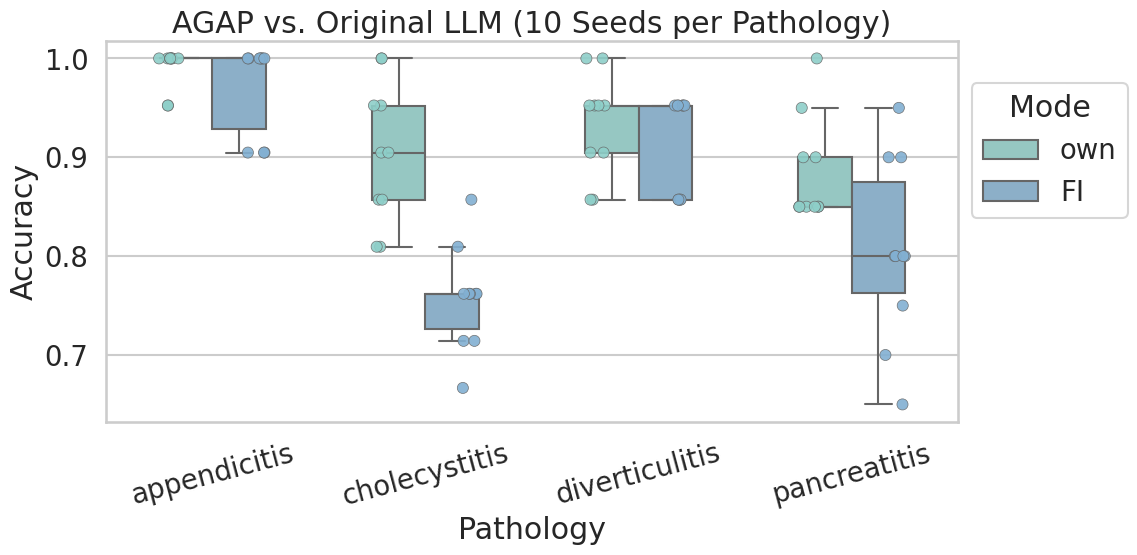

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered = df_long[ df_long['mode'].isin(['own', 'FI']) ]

sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)
palette = {'own':'#8ecfc9', 'FI': '#82b0d2'}

plt.figure(figsize=(12,6))
ax = sns.boxplot(x='pathology', y='accuracy', hue='mode', data=df_filtered, palette=palette, width=0.5, fliersize=0, linewidth=1.5)
sns.stripplot(x="pathology", y="accuracy", hue="mode", data=df_filtered, dodge=True, palette=palette, edgecolor="gray", linewidth=0.5, size=8, alpha=0.9)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Mode", loc="lower left", bbox_to_anchor=(1, 0.5))


plt.title("AGAP vs. Original LLM (10 Seeds per Pathology)")
plt.ylabel("Accuracy")
# plt.ylim(0.6, 1.00)
plt.xlabel("Pathology")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('AGAP_vs_Origin.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
doctor_acc = {
    'appendicitis': 0.96,
    'cholecystitis': 0.84,
    'diverticulitis': 0.86,
    'pancreatitis': 0.89
}
df_filtered = df_long[ df_long['mode'].isin(['own', 'FI']) ]

# 设置颜色
palette = {'own': '#1f77b4', 'FI': '#ff7f0e'}

# 计算模型均值准确率（柱状图数据）
bar_data = df_filtered.groupby(['pathology', 'mode'])['accuracy'].mean().reset_index()
print(bar_data)

        pathology mode  accuracy
0    appendicitis   FI  0.971429
1    appendicitis  own  0.990476
2   cholecystitis   FI  0.757143
3   cholecystitis  own  0.904762
4  diverticulitis   FI  0.914286
5  diverticulitis  own  0.933333
6    pancreatitis   FI  0.805000
7    pancreatitis  own  0.885000


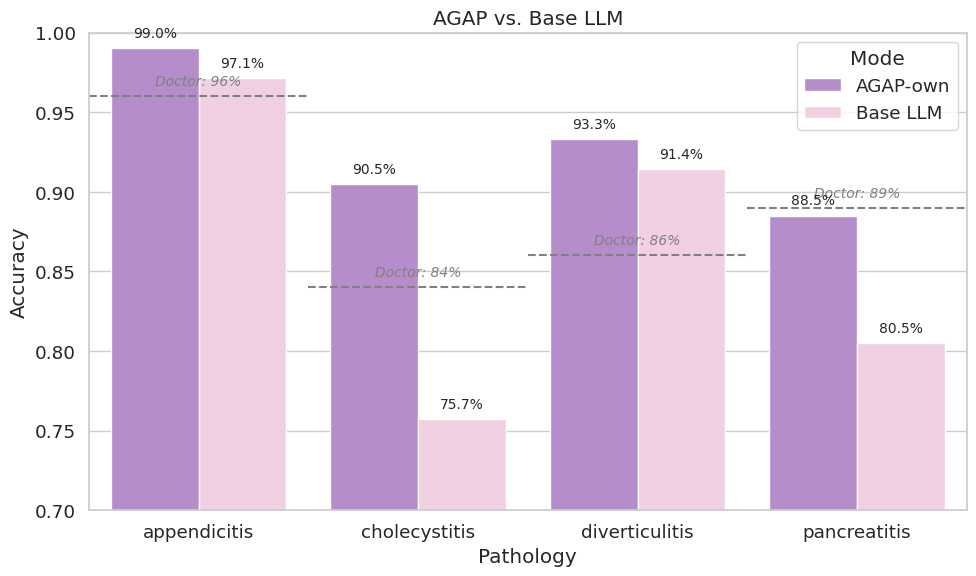

In [59]:
doctor_acc = {
    'appendicitis': 0.96,
    'cholecystitis': 0.84,
    'diverticulitis': 0.86,
    'pancreatitis': 0.89
}

mode_mapping = {
    'FI': 'Base LLM',
    'own': 'AGAP-own'  # 或 'AGAP (prompt: own)'，取决于你希望多详细
}

df_filtered = df_long[df_long['mode'].isin(['own', 'FI'])].copy()
df_filtered.loc[:, 'mode'] = df_filtered['mode'].map(mode_mapping)

# df_filtered = df_long[ df_long['mode'].isin(['Base LLM', 'AGAP-own']) ]

# 设置颜色
palette = {
    'AGAP-own': '#b883d4',
    'Base LLM': '#f6cae5'
}

# 计算模型均值准确率（柱状图数据）
bar_data = df_filtered.groupby(['pathology', 'mode'])['accuracy'].mean().reset_index()

# 设定图形大小与样式
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", font_scale=1.2)

# 绘制柱状图
ax = sns.barplot(x='pathology', y='accuracy', hue='mode', data=bar_data, palette=palette, errorbar=None)

# 添加医生准确率参考线
for i, pathology in enumerate(doctor_acc.keys()):
    plt.axhline(y=doctor_acc[pathology], color='gray', linestyle='--', linewidth=1.5, xmin=i*0.25, xmax=(i+1)*0.25)

# 添加医生准确率标签
for i, (pathology, acc) in enumerate(doctor_acc.items()):
    plt.text(i, acc + 0.005, f'Doctor: {acc*100:.0f}%', color='gray', ha='center', va='bottom', fontsize=10, style='italic')

# 添加准确率数值标签，跳过高度为 0 的柱子
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # 忽略高度为 0 的柱子
        ax.text(
            x=p.get_x() + p.get_width() / 2, 
            y=height + 0.005, 
            s=f'{height*100:.1f}%', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )


# 设定轴标签与标题
plt.ylim(0.7, 1.0)
plt.ylabel('Accuracy')
plt.xlabel('Pathology')
plt.title('AGAP vs. Base LLM')
plt.legend(title='Mode', loc='upper right')

plt.tight_layout()
plt.savefig("acc_comparison_with_doctors.png", dpi=300, bbox_inches='tight')
plt.show()

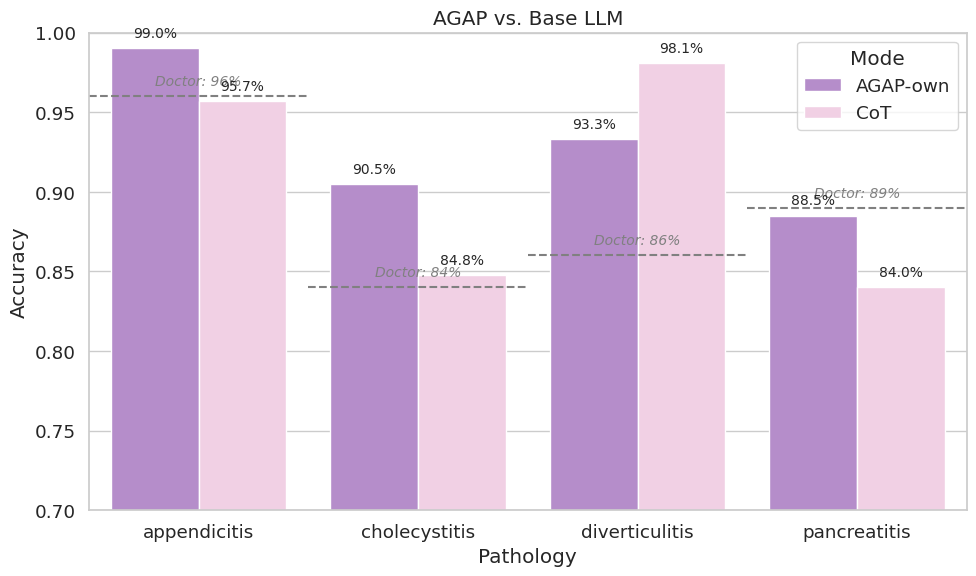

In [62]:
doctor_acc = {
    'appendicitis': 0.96,
    'cholecystitis': 0.84,
    'diverticulitis': 0.86,
    'pancreatitis': 0.89
}

mode_mapping = {
    'CoT': 'CoT',
    'own': 'AGAP-own'  # 或 'AGAP (prompt: own)'，取决于你希望多详细
}

df_filtered = df_long[df_long['mode'].isin(['own', 'CoT'])].copy()
df_filtered.loc[:, 'mode'] = df_filtered['mode'].map(mode_mapping)

# df_filtered = df_long[ df_long['mode'].isin(['Base LLM', 'AGAP-own']) ]

# 设置颜色
palette = {
    'AGAP-own': '#b883d4',
    'CoT': '#f6cae5'
}

# 计算模型均值准确率（柱状图数据）
bar_data = df_filtered.groupby(['pathology', 'mode'])['accuracy'].mean().reset_index()

# 设定图形大小与样式
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", font_scale=1.2)

# 绘制柱状图
ax = sns.barplot(x='pathology', y='accuracy', hue='mode', data=bar_data, palette=palette, errorbar=None)

# 添加医生准确率参考线
for i, pathology in enumerate(doctor_acc.keys()):
    plt.axhline(y=doctor_acc[pathology], color='gray', linestyle='--', linewidth=1.5, xmin=i*0.25, xmax=(i+1)*0.25)

# 添加医生准确率标签
for i, (pathology, acc) in enumerate(doctor_acc.items()):
    plt.text(i, acc + 0.005, f'Doctor: {acc*100:.0f}%', color='gray', ha='center', va='bottom', fontsize=10, style='italic')

# 添加准确率数值标签，跳过高度为 0 的柱子
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # 忽略高度为 0 的柱子
        ax.text(
            x=p.get_x() + p.get_width() / 2, 
            y=height + 0.005, 
            s=f'{height*100:.1f}%', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )


# 设定轴标签与标题
plt.ylim(0.7, 1.0)
plt.ylabel('Accuracy')
plt.xlabel('Pathology')
plt.title('AGAP vs. Base LLM')
plt.legend(title='Mode', loc='upper right')

plt.tight_layout()
plt.savefig("acc_comparison_with_doctors.png", dpi=300, bbox_inches='tight')
plt.show()

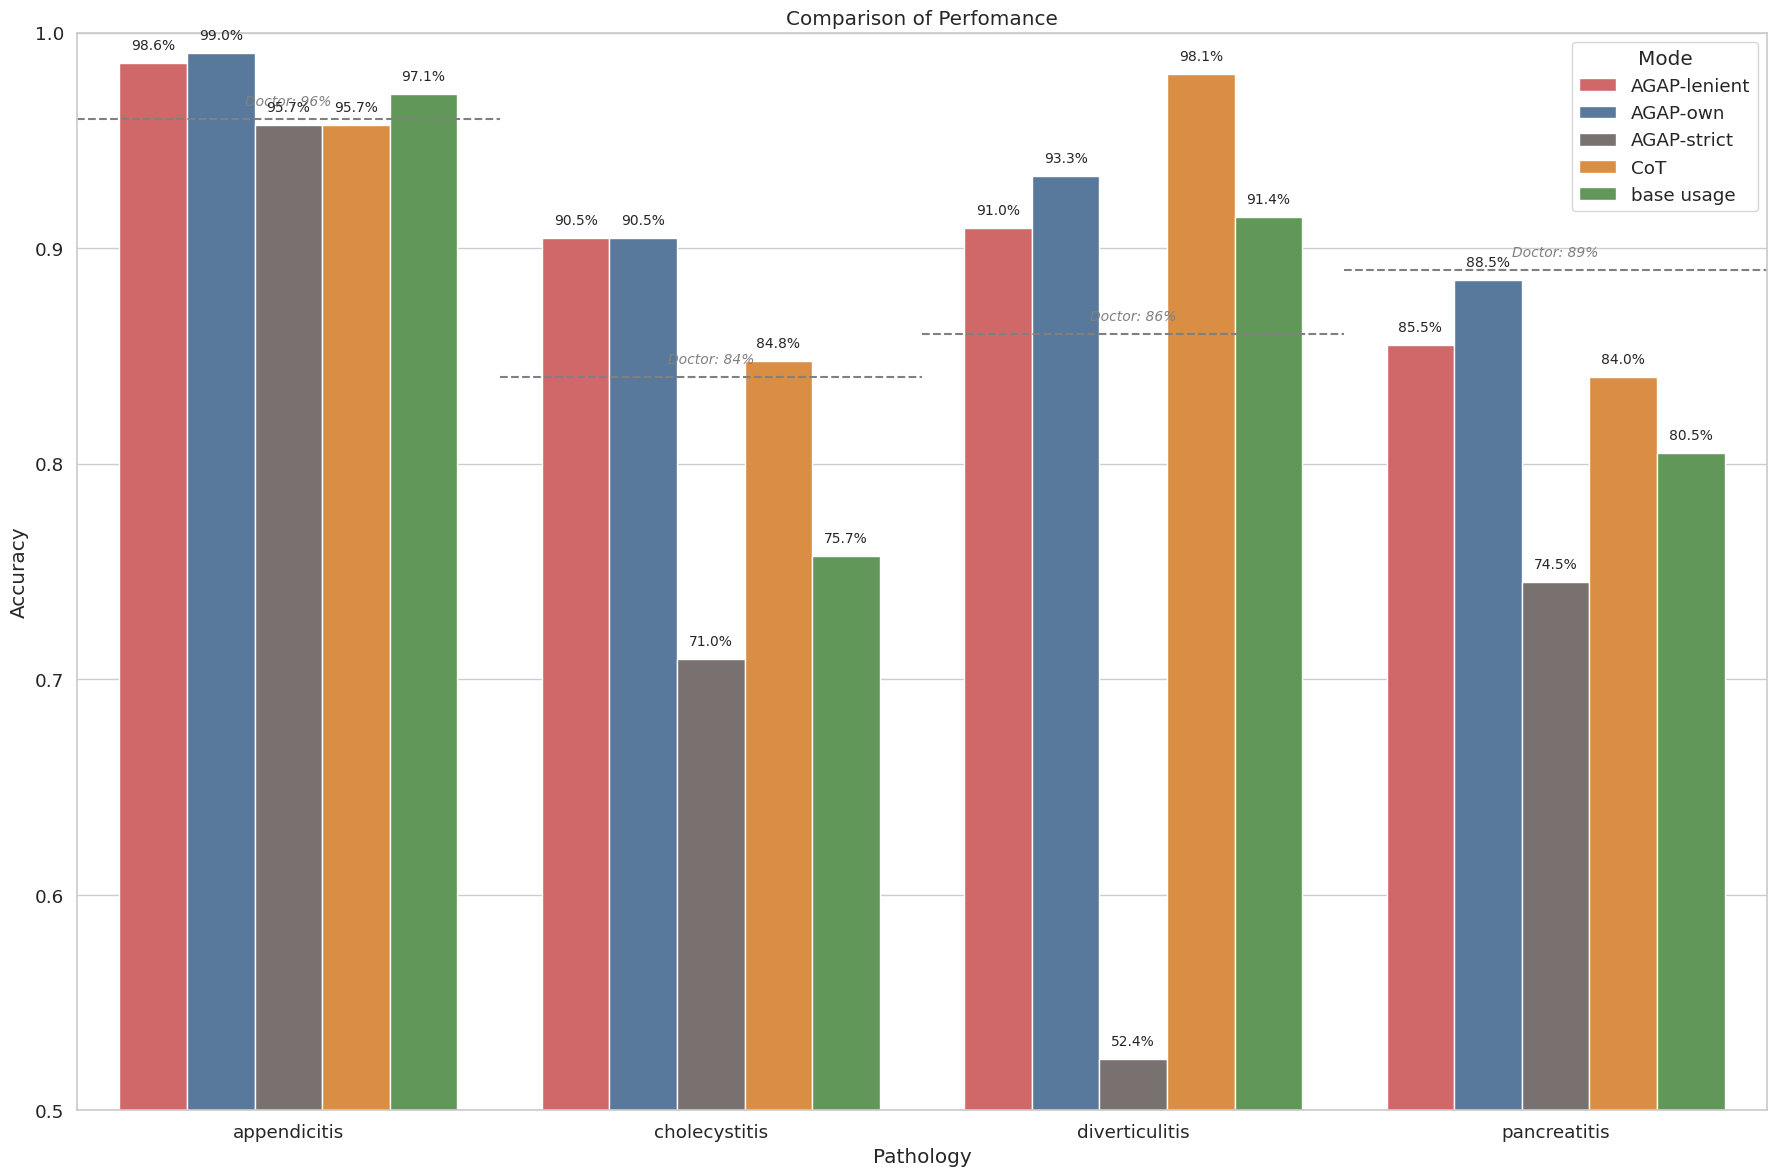

In [68]:
doctor_acc = {
    'appendicitis': 0.96,
    'cholecystitis': 0.84,
    'diverticulitis': 0.86,
    'pancreatitis': 0.89
}

mode_mapping = {
    'CoT': 'CoT',
    'own': 'AGAP-own',  # 或 'AGAP (prompt: own)'，取决于你希望多详细
    'FI': 'base usage',
    'lenient': 'AGAP-lenient',
    'strict': 'AGAP-strict'
}

df_filtered = df_long[df_long['mode'].isin(['own', 'CoT', 'FI', 'lenient', 'strict'])].copy()
df_filtered.loc[:, 'mode'] = df_filtered['mode'].map(mode_mapping)

# df_filtered = df_long[ df_long['mode'].isin(['Base LLM', 'AGAP-own']) ]

# 设置颜色
palette = {
    'AGAP-own': '#4E79A7',
    'CoT': '#F28E2B',
    'base usage': '#59A14F',
    'AGAP-lenient': '#E15759',
    'AGAP-strict': '#79706E'
}

# 计算模型均值准确率（柱状图数据）
bar_data = df_filtered.groupby(['pathology', 'mode'])['accuracy'].mean().reset_index()

# 设定图形大小与样式
plt.figure(figsize=(18, 12))
sns.set_theme(style="whitegrid", font_scale=1.2)

# 绘制柱状图
ax = sns.barplot(x='pathology', y='accuracy', hue='mode', data=bar_data, palette=palette, errorbar=None)

# 添加医生准确率参考线
for i, pathology in enumerate(doctor_acc.keys()):
    plt.axhline(y=doctor_acc[pathology], color='gray', linestyle='--', linewidth=1.5, xmin=i*0.25, xmax=(i+1)*0.25)

# 添加医生准确率标签
for i, (pathology, acc) in enumerate(doctor_acc.items()):
    plt.text(i, acc + 0.005, f'Doctor: {acc*100:.0f}%', color='gray', ha='center', va='bottom', fontsize=10, style='italic')

# 添加准确率数值标签，跳过高度为 0 的柱子
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # 忽略高度为 0 的柱子
        ax.text(
            x=p.get_x() + p.get_width() / 2, 
            y=height + 0.005, 
            s=f'{height*100:.1f}%', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )


# 设定轴标签与标题
plt.ylim(0.5, 1.0)
plt.ylabel('Accuracy')
plt.xlabel('Pathology')
plt.title('Comparison of Perfomance')
plt.legend(title='Mode', loc='upper right')

plt.tight_layout()
plt.savefig("All_5_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

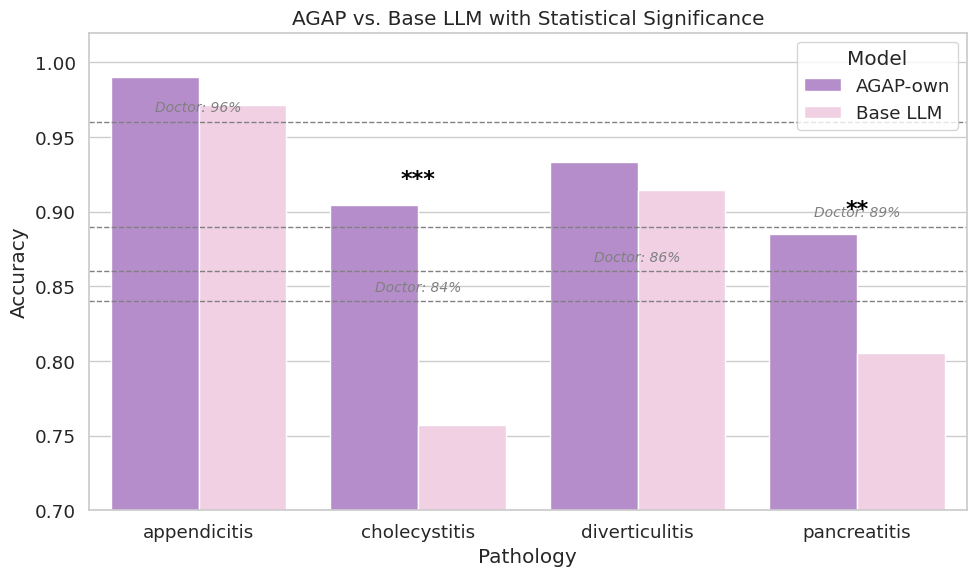

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 医生准确率
doctor_acc = {
    'appendicitis': 0.96,
    'cholecystitis': 0.84,
    'diverticulitis': 0.86,
    'pancreatitis': 0.89
}

# 模式映射
mode_mapping = {
    'FI': 'Base LLM',
    'own': 'AGAP-own'
}

# 显著性标记（根据 t 检验）
sig_labels = {
    'appendicitis': '',
    'cholecystitis': '***',
    'diverticulitis': '',
    'pancreatitis': '**'
}

# 筛选并映射模式名
df_filtered = df_long[df_long['mode'].isin(['own', 'FI'])].copy()
df_filtered['mode'] = df_filtered['mode'].map(mode_mapping)

# 设置颜色
palette = {
    'AGAP-own': '#b883d4',
    'Base LLM': '#f6cae5'
}

# 分组平均准确率
bar_data = df_filtered.groupby(['pathology', 'mode'])['accuracy'].mean().reset_index()

# 排序顺序
order = ['appendicitis', 'cholecystitis', 'diverticulitis', 'pancreatitis']

# 初始化画布
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", font_scale=1.2)

# 绘图
ax = sns.barplot(
    data=bar_data, x='pathology', y='accuracy',
    hue='mode', palette=palette, order=order, errorbar='se'
)

# 添加医生参考线和标签
for i, pathology in enumerate(order):
    acc = doctor_acc[pathology]
    ax.axhline(y=acc, color='gray', linestyle='--', linewidth=1)
    ax.text(i, acc + 0.005, f'Doctor: {acc*100:.0f}%', color='gray',
            ha='center', va='bottom', fontsize=10, style='italic')

# 添加显著性标记（*）
bar_width = 0.35
for i, pathology in enumerate(order):
    if sig_labels[pathology]:  # 如果有显著性标记
        # 获取两柱子中最大值
        group_vals = bar_data[bar_data['pathology'] == pathology]['accuracy'].values
        max_height = max(group_vals)
        # 位置略高于柱顶
        y = max_height + 0.01
        # 添加星号
        ax.text(i, y, sig_labels[pathology], ha='center', va='bottom',
                color='black', fontsize=16, fontweight='bold')

# 设置坐标轴等
plt.ylim(0.7, 1.02)
plt.ylabel('Accuracy')
plt.xlabel('Pathology')
plt.title('AGAP vs. Base LLM with Statistical Significance')
plt.legend(title='Model', loc='upper right')

plt.tight_layout()
plt.savefig("acc_comparison_with_significance.png", dpi=300, bbox_inches='tight')
plt.show()


# 可视化热图，呈现复杂病例下， 多个热图都容易错的现象

In [63]:
df_label_resutl = pd.read_excel('/media/luzhenyang/project/agent_graph_diag/results/statistical_result_of_diagnosis.xlsx',index_col=None, sheet_name='Accuracy_easy_to_call_tool')
df_label_resutl.drop(columns='Index', inplace=True)
df_label_resutl

,42_own,42_strict,42_lenient,42_FI,71_own,71_strict,71_lenient,71_FI,96_own,96_strict,96_lenient,96_FI,10_own,10_strict,10_lenient,10_FI,4_own,4_strict,4_lenient,4_FI
0,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对
1,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对
2,对,对,对,对,对,对,对,错,对,对,对,对,对,对,对,对,对,对,对,对
3,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对
4,对,对,对,对,对,对,对,错,对,对,对,对,对,对,对,对,对,对,对,对
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,对,对,对,对,对,对,对,对,空,空,空,空,对,对,对,对,对,对,对,对
76,对,错,错,错,对,对,对,对,对,对,对,对,错,空,错,错,对,对,对,对
77,对,对,对,对,对,空,对,空,对,对,对,对,错,空,错,错,错,对,对,空
78,对,对,对,对,对,对,空,对,对,对,对,错,对,对,对,对,空,空,空,空


In [64]:
df_label_resutl.replace('空', '错', inplace=True)
df_label_resutl


,42_own,42_strict,42_lenient,42_FI,71_own,71_strict,71_lenient,71_FI,96_own,96_strict,96_lenient,96_FI,10_own,10_strict,10_lenient,10_FI,4_own,4_strict,4_lenient,4_FI
0,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对
1,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对
2,对,对,对,对,对,对,对,错,对,对,对,对,对,对,对,对,对,对,对,对
3,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对,对
4,对,对,对,对,对,对,对,错,对,对,对,对,对,对,对,对,对,对,对,对
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,对,对,对,对,对,对,对,对,错,错,错,错,对,对,对,对,对,对,对,对
76,对,错,错,错,对,对,对,对,对,对,对,对,错,错,错,错,对,对,对,对
77,对,对,对,对,对,错,对,错,对,对,对,对,错,错,错,错,错,对,对,错
78,对,对,对,对,对,对,错,对,对,对,对,错,对,对,对,对,错,错,错,错


In [66]:
df_label_resutl = df_label_resutl.applymap(lambda x: 1 if x == '对' else 0 if x == '错' else pd.NA)
df_label_resutl['wrong_count'] = df_label_resutl.apply(lambda row: (row == 0).sum(), axis=1)

/tmp/ipykernel_25545/971190472.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_label_resutl = df_label_resutl.applymap(lambda x: 1 if x == '对' else 0 if x == '错' else pd.NA)


## 关于AGAP下3中prompts的性能比较

/tmp/ipykernel_40246/2755624338.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='pathology', y='accuracy', hue='mode', data=bar_data, palette=palette, ci=None)


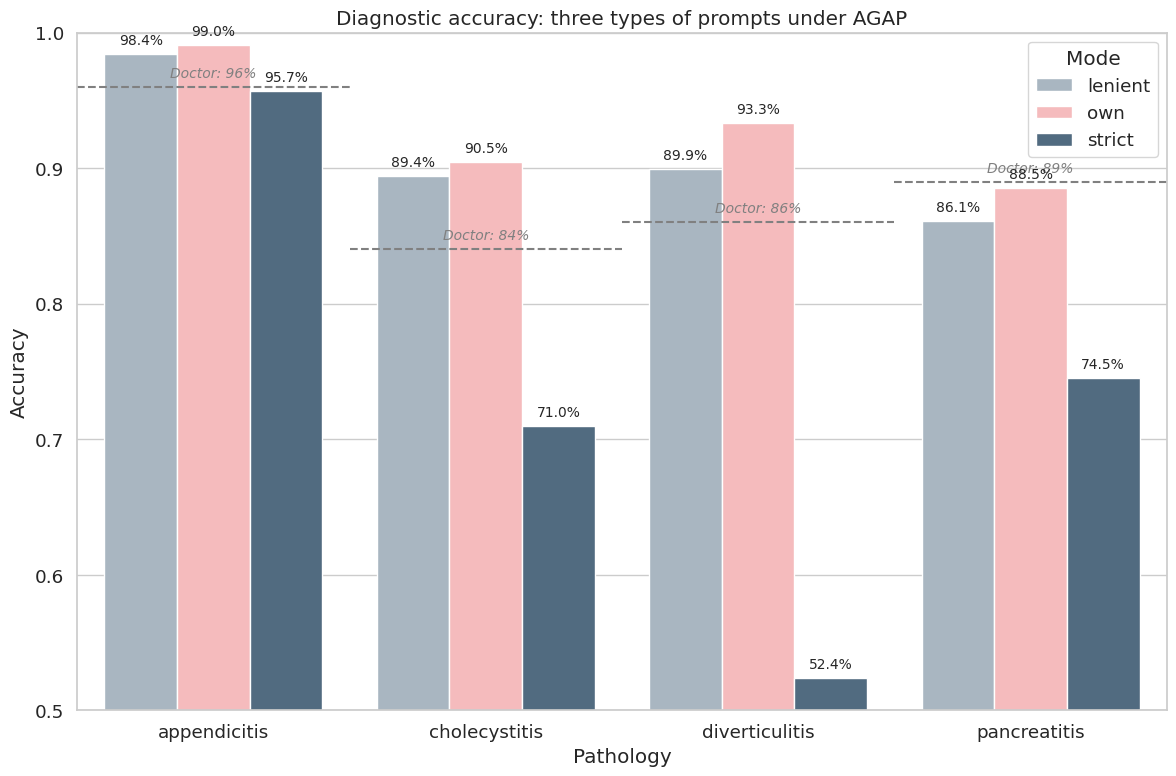

In [ ]:
doctor_acc = {
    'appendicitis': 0.96,
    'cholecystitis': 0.84,
    'diverticulitis': 0.86,
    'pancreatitis': 0.89
}
df_filtered = df_long[ df_long['mode'].isin(['own', 'strict', 'lenient']) ]

# 设置颜色
palette = {'own': '#feb2b4', 'strict': '#496c88', 'lenient': '#a5b6c5'}

# 计算模型均值准确率（柱状图数据）
bar_data = df_filtered.groupby(['pathology', 'mode'])['accuracy'].mean().reset_index()

# 设定图形大小与样式
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid", font_scale=1.2)

# 绘制柱状图
ax = sns.barplot(x='pathology', y='accuracy', hue='mode', data=bar_data, palette=palette, ci=None)

# 添加医生准确率参考线
for i, pathology in enumerate(doctor_acc.keys()):
    plt.axhline(y=doctor_acc[pathology], color='gray', linestyle='--', linewidth=1.5, xmin=i*0.25, xmax=(i+1)*0.25)

# 添加医生准确率标签
for i, (pathology, acc) in enumerate(doctor_acc.items()):
    plt.text(i, acc + 0.005, f'Doctor: {acc*100:.0f}%', color='gray', ha='center', va='bottom', fontsize=10, style='italic')

# 添加准确率数值标签，跳过高度为 0 的柱子
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # 忽略高度为 0 的柱子
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 0.005,
            s=f'{height*100:.1f}%',
            ha='center',
            va='bottom',
            fontsize=10
        )

# 设定轴标签与标题
plt.ylim(0.5, 1.0)
plt.ylabel('Accuracy')
plt.xlabel('Disease')
plt.title('Diagnostic accuracy: three types of prompts under AGAP')
plt.legend(title='Mode', loc='best')

plt.tight_layout()
plt.savefig("3_prompts_under_AGAP.png", dpi=300, bbox_inches='tight')
plt.show()

## 调用工具统计分析

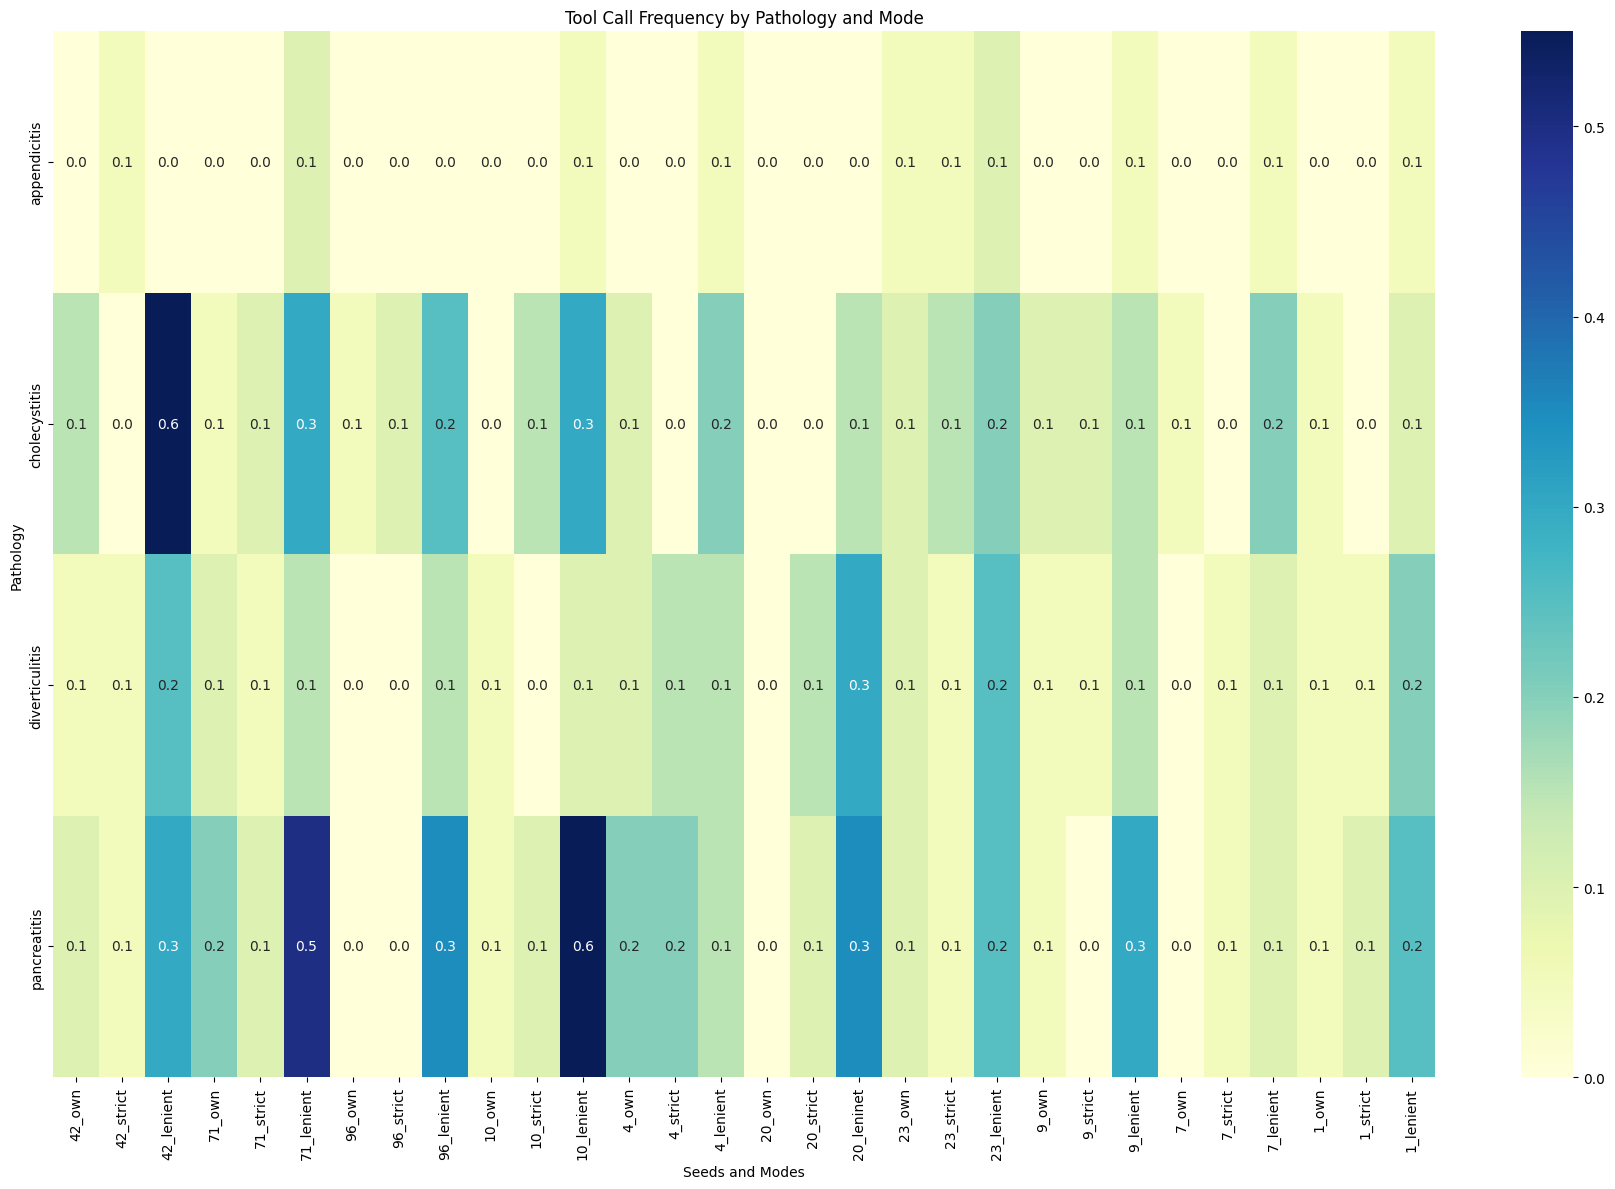

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取表格（假设 CSV 格式，你可以替换为实际文件路径）
df = pd.read_excel('/media/luzhenyang/project/agent_graph_diag/results/statistical_result_of_diagnosis.xlsx', sheet_name='Tool')

# 为每个样本添加疾病标签
diseases = ['appendicitis'] * 20 + ['cholecystitis'] * 20 + ['diverticulitis'] * 20 + ['pancreatitis'] * 20
df['disease'] = diseases

# 提取所有模式列（假设除了 Index 和 disease 其他都是）
mode_cols = [col for col in df.columns if col not in ['Index', 'disease']]

# 构造一个新的 DataFrame，记录每种模式下每个病理的调用频率（不论正确与否）
heatmap_data = pd.DataFrame(index=df['disease'].unique(), columns=mode_cols)

for mode in mode_cols:
    for disease in df['disease'].unique():
        # 取出对应模式和疾病的样本
        subset = df[df['disease'] == disease][mode]
        # 统计非空值（即调用了工具）
        call_rate = subset.notna().mean()
        heatmap_data.loc[disease, mode] = call_rate

# 转换为 float 类型
heatmap_data = heatmap_data.astype(float)

# 绘制热力图
plt.figure(figsize=(18, 12))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Tool Call Frequency by Pathology and Mode")
plt.ylabel("Pathology")
plt.xlabel("Seeds and Modes")
plt.tight_layout()
plt.savefig("Tool call frequency.png", dpi=500)
plt.show()


In [54]:
sta['42_own']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
        ...   
75         NaN
76    call-cor
77         NaN
78         NaN
79         NaN
Name: 42_own, Length: 80, dtype: object

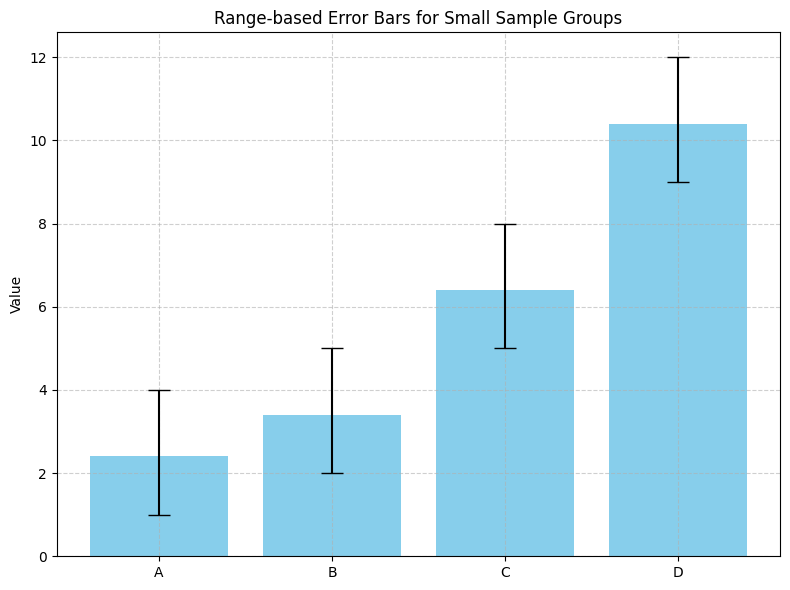

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 假设有 4 个组，每组样本量较小（例如5个）
group_names = ['A', 'B', 'C', 'D']
data = {
    'A': [1, 2, 2, 3, 4],
    'B': [3, 3, 5, 2, 4],
    'C': [6, 5, 7, 6, 8],
    'D': [10, 11, 9, 12, 10]
}

means = []
error_lowers = []
error_uppers = []

for group in group_names:
    values = data[group]
    mean = np.mean(values)
    min_val = np.min(values)
    max_val = np.max(values)

    means.append(mean)
    # 对称 error bar：从均值到最小/最大之间的差距
    error_lowers.append(mean - min_val)
    error_uppers.append(max_val - mean)

# 画带有 range 的 error bar
x_pos = np.arange(len(group_names))
plt.figure(figsize=(8, 6))
plt.bar(x_pos, means, yerr=[error_lowers, error_uppers], capsize=8, color='skyblue')
plt.xticks(x_pos, group_names)
plt.ylabel('Value')
plt.title('Range-based Error Bars for Small Sample Groups')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


# 可靠性分析的统计

In [56]:
import pandas as pd
import numpy as np

# --- 假设 df_all 已经根据你的代码生成 ---
# 这是一个示例 df_all，结构与你生成的一致
# 你应该使用你自己的 df_all
# data_for_demo = {
#     'seed': np.repeat(np.arange(1, 11), 5 * 4),
#     'method': np.tile(np.repeat(["ADW", "Vanilla Prompting", "CoT", "longformer", "clinical-longformer"], 4), 10),
#     'disease': np.tile(['Appendicitis', 'Cholecystitis', 'Diverticulitis', 'Pancreatitis'], 5 * 10),
#     'accuracy': np.random.rand(200) # 随机数据仅为演示
# }
# df_all = pd.DataFrame(data_for_demo)
# ==== Paths ====
llm_csv = "/media/luzhenyang/project/agent_graph_diag/statistics/type_accuracy_by_pathology.csv"
longformer_csv = "/media/luzhenyang/project/agent_graph_diag/lm_classification/normal_longformer_perclass_accuracy.csv"
clinical_csv = "/media/luzhenyang/project/agent_graph_diag/lm_classification/clinical_longformer_perclass_accuracy.csv"
output_dir = "/media/luzhenyang/project/agent_graph_diag/statistics/AGAP_main_comp"
os.makedirs(output_dir, exist_ok=True)

# ==== New method names ====
method_order = ["own", 'lenient', 'strict', "Vanilla Prompting", "CoT", "longformer", "clinical-longformer"]

# ==== Load and parse LLM data ====
df_llm = pd.read_csv(llm_csv, index_col=0)

# ==== Map raw method labels ====
method_rename_map = {
    'own': 'own',
    'strict': 'strict',
    'lenient': 'lenient',
    'FI': 'Vanilla Prompting',
    'CoT': 'CoT'
}

# ==== Filter and rename columns ====
df_llm_filtered = df_llm.loc[:, df_llm.columns.str.contains('own|strict|lenient|FI|CoT')]

long_data = []
for col in df_llm_filtered.columns:
    seed, raw_method = col.split('_')
    method = method_rename_map.get(raw_method, raw_method)  # Rename here
    for disease in df_llm.index:
        acc = df_llm.loc[disease, col]
        long_data.append({
            'seed': int(seed),
            'method': method,
            'disease': disease,
            'accuracy': acc
        })

# ==== Longformer ====
df_longformer = pd.read_csv(longformer_csv)
df_longformer = df_longformer.melt(id_vars=['Seed'], var_name='disease', value_name='accuracy')
df_longformer['method'] = 'longformer'
df_longformer.rename(columns={'Seed': 'seed'}, inplace=True)

# ==== Clinical-Longformer ====
df_clinical = pd.read_csv(clinical_csv)
df_clinical = df_clinical.melt(id_vars=['Seed'], var_name='disease', value_name='accuracy')
df_clinical['method'] = 'clinical-longformer'
df_clinical.rename(columns={'Seed': 'seed'}, inplace=True)

# ==== Merge all ====
df_all = pd.concat([pd.DataFrame(long_data), df_longformer, df_clinical], ignore_index=True)
# ---------------------------------------------


# --- 核心计算步骤 ---
# 1. 按 'seed' 和 'method' 分组
# 2. 计算每个组内 (即每一次独立运行中某个方法的) 的平均准确率。
#    由于每个疾病的样本量相同(20例)，对四个疾病的准确率求平均，
#    就等于该方法在该次运行中的总准确率。
overall_accuracy_per_run = df_all.groupby(['seed', 'method'])['accuracy'].mean().reset_index()

# 3. 现在我们有了每个方法在10次运行中的总准确率。
#    接下来，我们按 'method' 分组，计算这10个准确率的均值和标准差。
reliability_stats = overall_accuracy_per_run.groupby('method')['accuracy'].agg(['mean', 'std']).reset_index()

# 4. 格式化结果以便呈现
reliability_stats['mean'] = reliability_stats['mean'] * 100  # 转换为百分比
reliability_stats['std'] = reliability_stats['std'] * 100   # 转换为百分比
reliability_stats = reliability_stats.rename(columns={
    'method': 'Method',
    'mean': 'Mean Overall Accuracy (%)',
    'std': 'Standard Deviation (SD, %)'
})

# 5. 确保表格顺序与你的研究一致
# method_order = ["ADW", "Vanilla Prompting", "CoT", "longformer", "clinical-longformer"]
method_order = ["own", 'lenient', 'strict', "Vanilla Prompting", "CoT", "longformer", "clinical-longformer"]
# 如果还有ADW-strict和lenient，也加在这里
# method_order = ["ADW", "ADW-lenient", "ADW-strict", "Vanilla Prompting", "CoT", "longformer", "clinical-longformer"]

reliability_stats['Method'] = pd.Categorical(reliability_stats['Method'], categories=method_order, ordered=True)
reliability_stats = reliability_stats.sort_values('Method')


# --- 生成最终的Markdown表格 ---
print("--- Reliability Analysis Table ---")
print(reliability_stats.to_markdown(index=False, tablefmt="grid", floatfmt=(".1f", ".1f", ".2f")))

--- Reliability Analysis Table ---
+---------------------+-----------------------------+------------------------------+
| Method              |   Mean Overall Accuracy (%) |   Standard Deviation (SD, %) |
+=====================+=============================+==============================+
| own                 |                        92.8 |                         2.87 |
+---------------------+-----------------------------+------------------------------+
| lenient             |                        91.5 |                         3.81 |
+---------------------+-----------------------------+------------------------------+
| strict              |                        73.5 |                         5.38 |
+---------------------+-----------------------------+------------------------------+
| Vanilla Prompting   |                        86.2 |                         4.30 |
+---------------------+-----------------------------+------------------------------+
| CoT                 |       